In [100]:
import wave
import json
import librosa
import csv
import numpy as np
from pywt import wavedec
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [101]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [102]:
import wave
import json

def reset_csv():
  header = 'filename'
  for i in range(1, 41):
      header += f' mfcc{i}'
  for i in range(1, 13):
    header += f' chroma{i}'
  for i in range(1, 61):
    header += f' cqt{i}'
  header += ' label'
  header = header.split()
  file = open('testing.csv', 'w', newline='')
  with file:
      writer = csv.writer(file)
      writer.writerow(header)

In [103]:
def getModelArray(model_name):
  model_path = '../modelh5/'+model_name+'/best_model/'
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(model_path)):
    filenames.sort()
    filenames = filenames[10:] + filenames[:10]
    # cut each 10 array
    filenames = [filenames[i:i + 10] for i in range(0, len(filenames), 10)]
    return filenames[0], filenames[1], filenames[2], filenames[3], filenames[4], filenames[5], filenames[6], filenames[7], filenames[8], filenames[9]

def getPathModel(model_name):
  a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = getModelArray(model_name)
  # switch index 2 to 10
  hasil = []
  for i in [a1, a2, a3, a4, a5, a6, a7, a8, a9, a10]:
    a = i[1]
    i.pop(1)
    i.append(a)
    for j in range(len(i)):
      i[j] = '../modelh5/'+model_name + '/best_model/' + i[j]
  return a1, a2, a3, a4, a5, a6, a7, a8, a9, a10

In [104]:
def testingVHD(array, db):
    index_db = 0
    accuracy_all = []
    precision_all = []
    sensitivity_all = []
    specificity_all = []
    f1_score_all = []

    for model_path in array:
        print("=======================================================")
        print("Processing "+ model_path)
        print("=======================================================")
        dataset_path = '../../data/testing_10/'
        reset_csv()

        for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
                # ensure we're processing a genre sub-folder level
                if dirpath is not dataset_path:
                    semantic_label = dirpath.split("/")[-1]
                    for f in filenames:
                        file_path = os.path.join(dirpath, f)
                        to_append = f'{file_path}'
                        # print(file_path)
                        y, sr = librosa.load(file_path, mono=True, duration=3, sr=8000)
                        coeffs = wavedec(y, f'db{db}', level=10)
                        cA,cD10,cD9,cD8,cD7,cD6,cD5,cD4,cD3,cD2, cD1 = coeffs
                        list_cd = [cD1, cD2, cD3, cD4, cD5, cD6, cD7, cD8, cD9, cD10]
                        mfcc = librosa.feature.mfcc(y=list_cd[index_db], sr=8000, n_mfcc=40, n_fft=2048, hop_length=512, n_mels=128)
                        rms = librosa.feature.chroma_stft(y=list_cd[index_db], sr=8000)
                        cqt = np.abs(librosa.cqt(y=list_cd[index_db], sr=sr, n_bins=60))
                        combined_features = np.concatenate((mfcc, rms, cqt), axis=0)
                        to_append = f'{file_path}'
                        for e in combined_features:
                            to_append += f' {np.mean(e.T, axis=0)}'
                        to_append += f' {semantic_label}'
                        file = open('testing.csv', 'a', newline='')
                        with file:
                            writer = csv.writer(file)
                            writer.writerow(to_append.split())
        index_db += 1
        data = pd.read_csv('./testing.csv')
        
        lb = LabelEncoder()
        X = np.expand_dims(data.drop(['label', 'filename'], axis=1), axis=2)
        y = np.expand_dims(data.iloc[:, -1], axis=1)


        model = tf.keras.models.load_model(model_path)
        pred = model.predict(X)
        hasil = []
        class_labels = ['AS', 'MR', 'MS', 'MVP', 'N']
        # class_labels = ['MVP', 'MS', 'N', 'MR', 'AS']
        for predic in pred:
            cek = np.argmax(predic)
            hasil.append(class_labels[cek])
        # y_p = np.argmax(pred, axis=1)

        cm = confusion_matrix(y, hasil)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['AS', 'MR', 'MS', 'MVP', 'N'])
        disp.plot()
        plt.show()

        FP = cm.sum(axis=0) - np.diag(cm)  
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        TN = cm.sum() - (FP + FN + TP)

        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        # Specificity or true negative rate
        TNR = TN/(TN+FP) 
        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        # Negative predictive value
        NPV = TN/(TN+FN)
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        # False negative rate
        FNR = FN/(TP+FN)
        # False discovery rate
        FDR = FP/(TP+FP)

        # Overall accuracy
        ACC = (TP+TN)/(TP+FP+FN+TN)

        print("Accuracy :" , ACC, 'mean: ', np.mean(ACC))
        print("Precision :" , PPV, 'mean: ', np.mean(PPV))
        print("Sensitivity :" , TPR, 'mean: ', np.mean(TPR))
        print("Specificity :" , TNR, 'mean: ', np.mean(TNR))
        print("f1_score:", 2 * (PPV * TPR) / (PPV + TPR), 'mean: ', np.mean(2 * (PPV * TPR) / (PPV + TPR)))

        accuracy_all.append(np.mean(ACC))
        precision_all.append(np.mean(PPV))
        sensitivity_all.append(np.mean(TPR))
        specificity_all.append(np.mean(TNR))
        f1_score_all.append(np.mean(2 * (PPV * TPR) / (PPV + TPR)))

        print("\n\n")

    print("=======================================================")
    print("Accuracy All :" , accuracy_all)
    print("Precision All :" , precision_all)
    print("Sensitivity All :" , sensitivity_all)
    print("Specificity All :" , specificity_all)
    print("f1_score All :", f1_score_all)
    print("=======================================================")




In [105]:
a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = getPathModel("CNN_NT")

Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb1L1.csv_2.h5


4/4 [==============================] - 0s 3ms/step


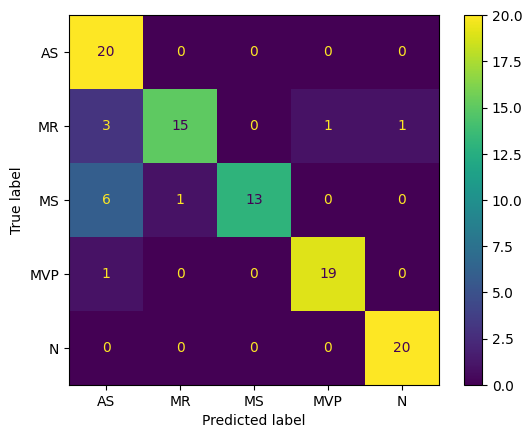

Accuracy : [0.9  0.94 0.93 0.98 0.99] mean:  0.9480000000000001
Precision : [0.66666667 0.9375     1.         0.95       0.95238095] mean:  0.9013095238095238
Sensitivity : [1.   0.75 0.65 0.95 1.  ] mean:  0.8699999999999999
Specificity : [0.875  0.9875 1.     0.9875 0.9875] mean:  0.9674999999999999
f1_score: [0.8        0.83333333 0.78787879 0.95       0.97560976] mean:  0.8693643754619366



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb1L2.csv_2.h5
4/4 [==============================] - 0s 3ms/step


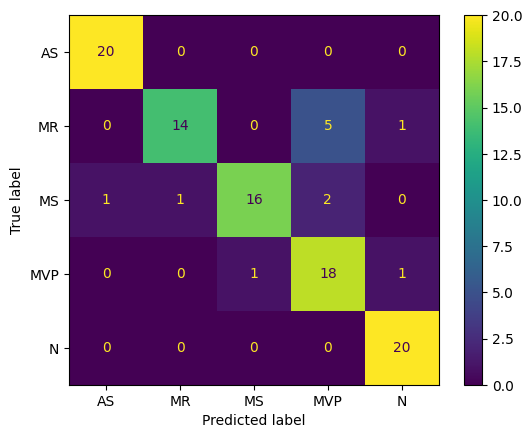

Accuracy : [0.99 0.93 0.95 0.91 0.98] mean:  0.952
Precision : [0.95238095 0.93333333 0.94117647 0.72       0.90909091] mean:  0.891196333078686
Sensitivity : [1.  0.7 0.8 0.9 1. ] mean:  0.8800000000000001
Specificity : [0.9875 0.9875 0.9875 0.9125 0.975 ] mean:  0.9700000000000001
f1_score: [0.97560976 0.8        0.86486486 0.8        0.95238095] mean:  0.8785711146686757



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb1L3.csv_2.h5
4/4 [==============================] - 0s 2ms/step


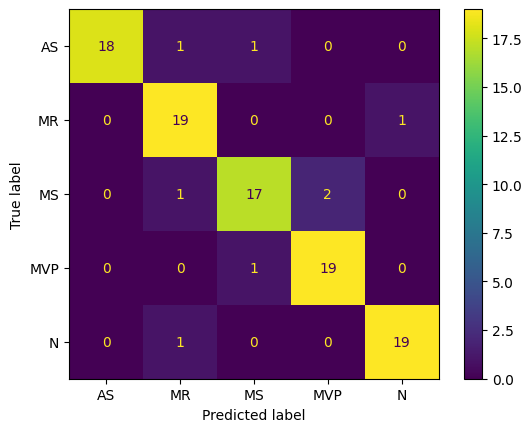

Accuracy : [0.98 0.96 0.95 0.97 0.98] mean:  0.968
Precision : [1.         0.86363636 0.89473684 0.9047619  0.95      ] mean:  0.9226270221007062
Sensitivity : [0.9  0.95 0.85 0.95 0.95] mean:  0.9200000000000002
Specificity : [1.     0.9625 0.975  0.975  0.9875] mean:  0.9800000000000001
f1_score: [0.94736842 0.9047619  0.87179487 0.92682927 0.95      ] mean:  0.9201508931804183



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb1L4.csv_3.h5
4/4 [==============================] - 0s 2ms/step


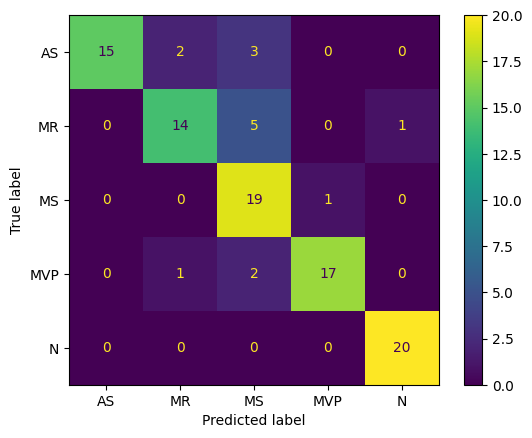

Accuracy : [0.95 0.91 0.89 0.96 0.99] mean:  0.9400000000000001
Precision : [1.         0.82352941 0.65517241 0.94444444 0.95238095] mean:  0.8751054444766412
Sensitivity : [0.75 0.7  0.95 0.85 1.  ] mean:  0.85
Specificity : [1.     0.9625 0.875  0.9875 0.9875] mean:  0.9625
f1_score: [0.85714286 0.75675676 0.7755102  0.89473684 0.97560976] mean:  0.8519512832368141



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb1L5.csv_2.h5
4/4 [==============================] - 0s 3ms/step


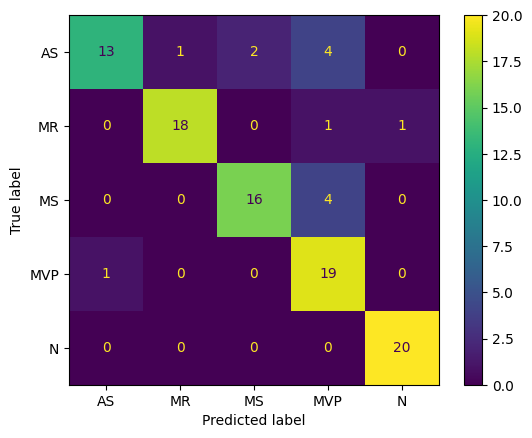

Accuracy : [0.92 0.97 0.94 0.9  0.99] mean:  0.944
Precision : [0.92857143 0.94736842 0.88888889 0.67857143 0.95238095] mean:  0.8791562238930661
Sensitivity : [0.65 0.9  0.8  0.95 1.  ] mean:  0.86
Specificity : [0.9875 0.9875 0.975  0.8875 0.9875] mean:  0.9650000000000001
f1_score: [0.76470588 0.92307692 0.84210526 0.79166667 0.97560976] mean:  0.8594328982703974



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb1L6.csv_3.h5
4/4 [==============================] - 0s 3ms/step


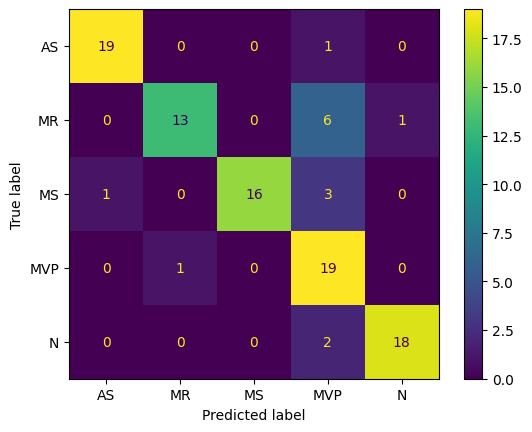

Accuracy : [0.98 0.92 0.96 0.87 0.97] mean:  0.9400000000000001
Precision : [0.95       0.92857143 1.         0.61290323 0.94736842] mean:  0.8877686150861024
Sensitivity : [0.95 0.65 0.8  0.95 0.9 ] mean:  0.8500000000000002
Specificity : [0.9875 0.9875 1.     0.85   0.9875] mean:  0.9625
f1_score: [0.95       0.76470588 0.88888889 0.74509804 0.92307692] mean:  0.8543539467068879



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb1L7.csv_2.h5
4/4 [==============================] - 0s 2ms/step


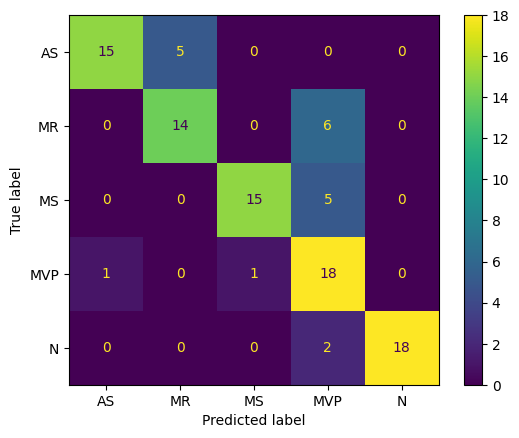

Accuracy : [0.94 0.89 0.94 0.85 0.98] mean:  0.9199999999999999
Precision : [0.9375     0.73684211 0.9375     0.58064516 1.        ] mean:  0.8384974533106961
Sensitivity : [0.75 0.7  0.75 0.9  0.9 ] mean:  0.8
Specificity : [0.9875 0.9375 0.9875 0.8375 1.    ] mean:  0.95
f1_score: [0.83333333 0.71794872 0.83333333 0.70588235 0.94736842] mean:  0.8075732317218385



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb1L8.csv_2.h5
4/4 [==============================] - 0s 2ms/step


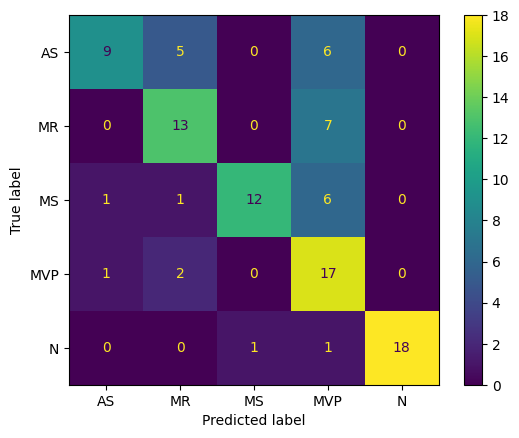

Accuracy : [0.87 0.85 0.91 0.77 0.98] mean:  0.876
Precision : [0.81818182 0.61904762 0.92307692 0.45945946 1.        ] mean:  0.763953163953164
Sensitivity : [0.45 0.65 0.6  0.85 0.9 ] mean:  0.6900000000000001
Specificity : [0.975  0.9    0.9875 0.75   1.    ] mean:  0.9225
f1_score: [0.58064516 0.63414634 0.72727273 0.59649123 0.94736842] mean:  0.6971847758298544



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb1L9.csv_4.h5
4/4 [==============================] - 0s 2ms/step


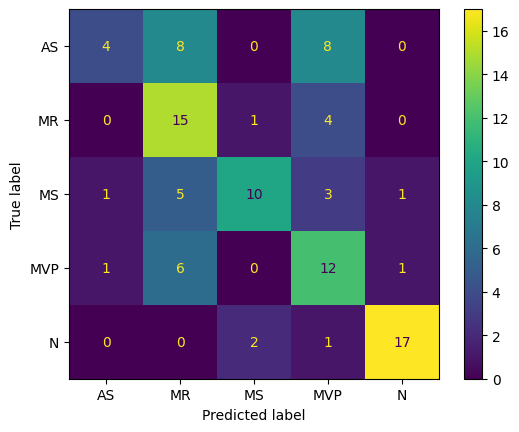

Accuracy : [0.82 0.76 0.87 0.76 0.95] mean:  0.8320000000000001
Precision : [0.66666667 0.44117647 0.76923077 0.42857143 0.89473684] mean:  0.6400764354324726
Sensitivity : [0.2  0.75 0.5  0.6  0.85] mean:  0.58
Specificity : [0.975  0.7625 0.9625 0.8    0.975 ] mean:  0.8949999999999999
f1_score: [0.30769231 0.55555556 0.60606061 0.5        0.87179487] mean:  0.5682206682206682



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb1L10.csv_5.h5
4/4 [==============================] - 0s 2ms/step


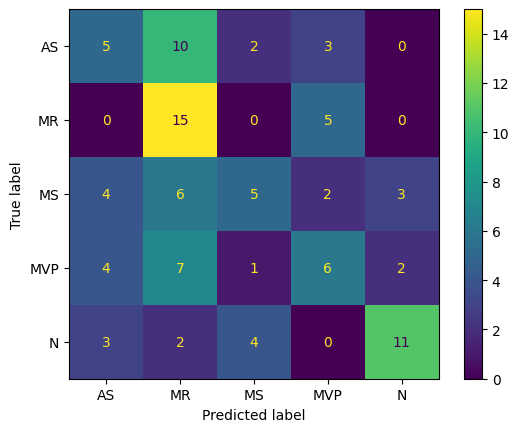

Accuracy : [0.74 0.7  0.78 0.76 0.86] mean:  0.7679999999999999
Precision : [0.3125     0.375      0.41666667 0.375      0.6875    ] mean:  0.4333333333333334
Sensitivity : [0.25 0.75 0.25 0.3  0.55] mean:  0.42000000000000004
Specificity : [0.8625 0.6875 0.9125 0.875  0.9375] mean:  0.8550000000000001
f1_score: [0.27777778 0.5        0.3125     0.33333333 0.61111111] mean:  0.40694444444444444



Accuracy All : [0.9480000000000001, 0.952, 0.968, 0.9400000000000001, 0.944, 0.9400000000000001, 0.9199999999999999, 0.876, 0.8320000000000001, 0.7679999999999999]
Precision All : [0.9013095238095238, 0.891196333078686, 0.9226270221007062, 0.8751054444766412, 0.8791562238930661, 0.8877686150861024, 0.8384974533106961, 0.763953163953164, 0.6400764354324726, 0.4333333333333334]
Sensitivity All : [0.8699999999999999, 0.8800000000000001, 0.9200000000000002, 0.85, 0.86, 0.8500000000000002, 0.8, 0.6900000000000001, 0.58, 0.42000000000000004]
Specificity All : [0.9674999999999999, 0.9700000000000001

In [106]:
testingVHD(a1, 1)

Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb2L1.csv_2.h5
4/4 [==============================] - 0s 2ms/step


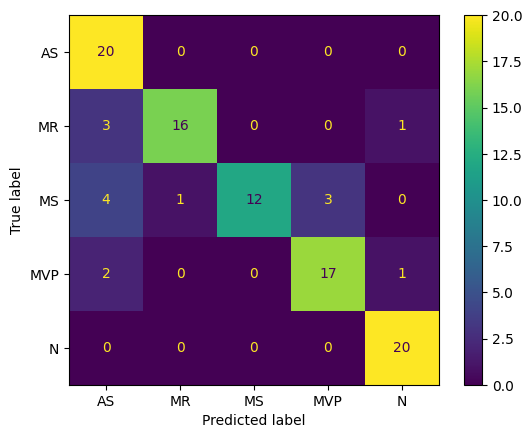

Accuracy : [0.91 0.95 0.92 0.94 0.98] mean:  0.9399999999999998
Precision : [0.68965517 0.94117647 1.         0.85       0.90909091] mean:  0.8779845104185874
Sensitivity : [1.   0.8  0.6  0.85 1.  ] mean:  0.85
Specificity : [0.8875 0.9875 1.     0.9625 0.975 ] mean:  0.9625
f1_score: [0.81632653 0.86486486 0.75       0.85       0.95238095] mean:  0.8467144695716124



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb2L2.csv_2.h5
4/4 [==============================] - 0s 3ms/step


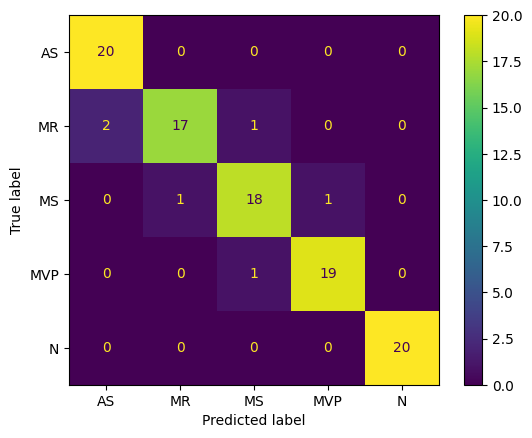

Accuracy : [0.98 0.96 0.96 0.98 1.  ] mean:  0.976
Precision : [0.90909091 0.94444444 0.9        0.95       1.        ] mean:  0.9407070707070707
Sensitivity : [1.   0.85 0.9  0.95 1.  ] mean:  0.9400000000000001
Specificity : [0.975  0.9875 0.975  0.9875 1.    ] mean:  0.985
f1_score: [0.95238095 0.89473684 0.9        0.95       1.        ] mean:  0.9394235588972432



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb2L3.csv_5.h5
4/4 [==============================] - 0s 2ms/step


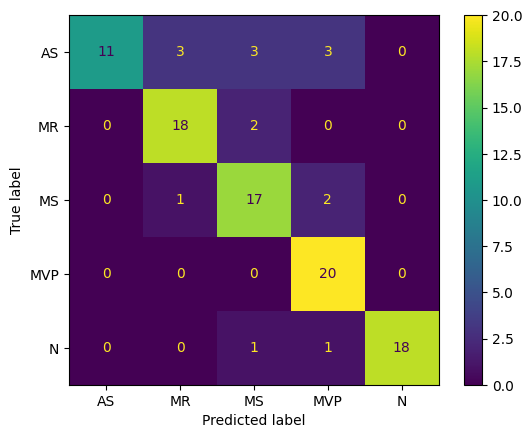

Accuracy : [0.91 0.94 0.91 0.94 0.98] mean:  0.9359999999999999
Precision : [1.         0.81818182 0.73913043 0.76923077 1.        ] mean:  0.8653086044390392
Sensitivity : [0.55 0.9  0.85 1.   0.9 ] mean:  0.8400000000000001
Specificity : [1.    0.95  0.925 0.925 1.   ] mean:  0.96
f1_score: [0.70967742 0.85714286 0.79069767 0.86956522 0.94736842] mean:  0.8348903178720473



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb2L4.csv_5.h5
4/4 [==============================] - 0s 2ms/step


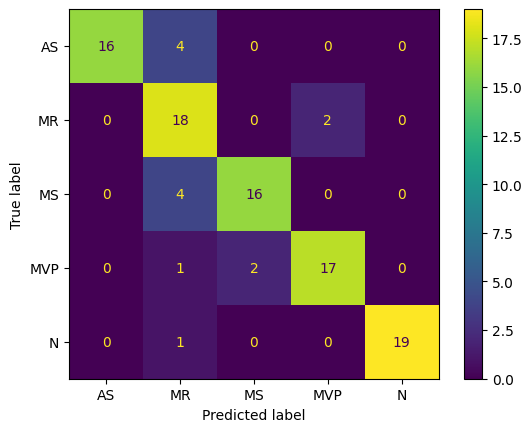

Accuracy : [0.96 0.88 0.94 0.95 0.99] mean:  0.944
Precision : [1.         0.64285714 0.88888889 0.89473684 1.        ] mean:  0.885296574770259
Sensitivity : [0.8  0.9  0.8  0.85 0.95] mean:  0.86
Specificity : [1.    0.875 0.975 0.975 1.   ] mean:  0.9650000000000001
f1_score: [0.88888889 0.75       0.84210526 0.87179487 0.97435897] mean:  0.865429599640126



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb2L5.csv_5.h5
4/4 [==============================] - 0s 2ms/step


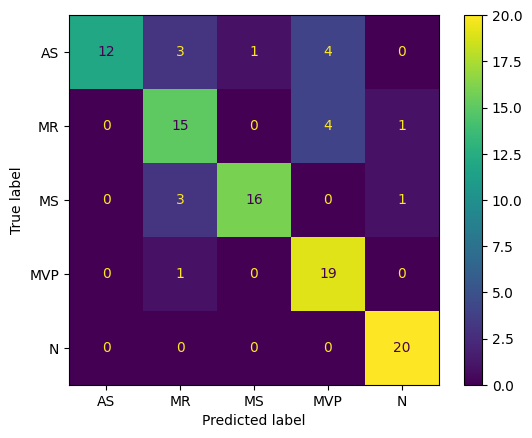

Accuracy : [0.92 0.88 0.95 0.91 0.98] mean:  0.9280000000000002
Precision : [1.         0.68181818 0.94117647 0.7037037  0.90909091] mean:  0.847157853040206
Sensitivity : [0.6  0.75 0.8  0.95 1.  ] mean:  0.8200000000000001
Specificity : [1.     0.9125 0.9875 0.9    0.975 ] mean:  0.9550000000000001
f1_score: [0.75       0.71428571 0.86486486 0.80851064 0.95238095] mean:  0.8180084339658806



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb2L6.csv_3.h5
4/4 [==============================] - 0s 3ms/step


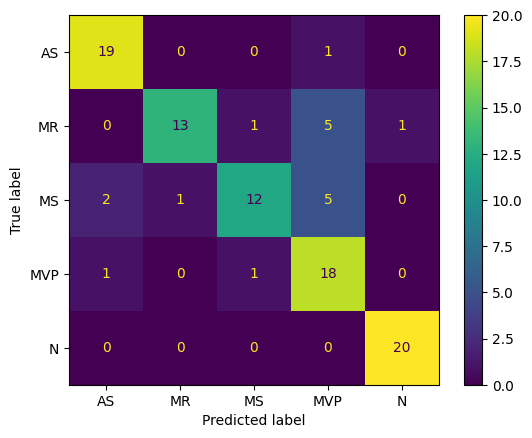

Accuracy : [0.96 0.92 0.9  0.87 0.99] mean:  0.9279999999999999
Precision : [0.86363636 0.92857143 0.85714286 0.62068966 0.95238095] mean:  0.8444842513808031
Sensitivity : [0.95 0.65 0.6  0.9  1.  ] mean:  0.82
Specificity : [0.9625 0.9875 0.975  0.8625 0.9875] mean:  0.9550000000000001
f1_score: [0.9047619  0.76470588 0.70588235 0.73469388 0.97560976] mean:  0.8171307547409207



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb2L7.csv_2.h5
4/4 [==============================] - 0s 2ms/step


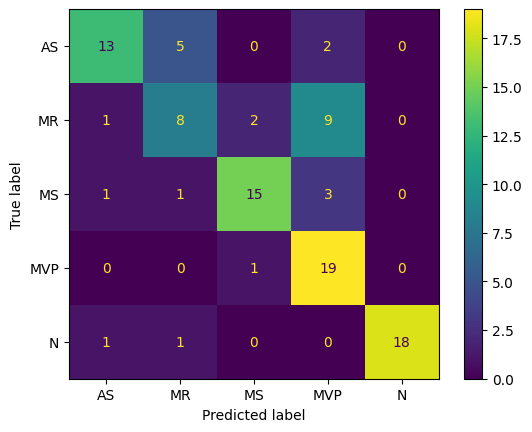

Accuracy : [0.9  0.81 0.92 0.85 0.98] mean:  0.892
Precision : [0.8125     0.53333333 0.83333333 0.57575758 1.        ] mean:  0.7509848484848485
Sensitivity : [0.65 0.4  0.75 0.95 0.9 ] mean:  0.73
Specificity : [0.9625 0.9125 0.9625 0.825  1.    ] mean:  0.9324999999999999
f1_score: [0.72222222 0.45714286 0.78947368 0.71698113 0.94736842] mean:  0.7266376633407419



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb2L8.csv_2.h5
4/4 [==============================] - 0s 2ms/step


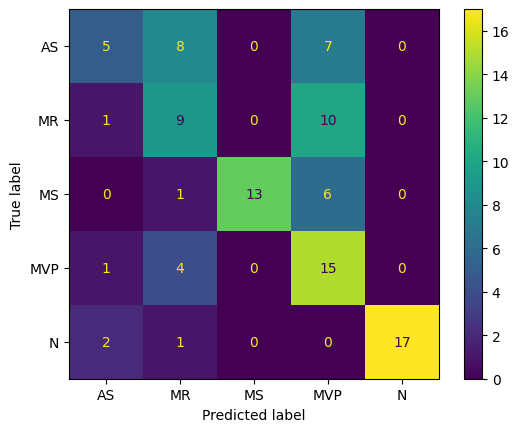

Accuracy : [0.81 0.75 0.93 0.72 0.97] mean:  0.836
Precision : [0.55555556 0.39130435 1.         0.39473684 1.        ] mean:  0.6683193490973811
Sensitivity : [0.25 0.45 0.65 0.75 0.85] mean:  0.5900000000000001
Specificity : [0.95   0.825  1.     0.7125 1.    ] mean:  0.8975
f1_score: [0.34482759 0.41860465 0.78787879 0.51724138 0.91891892] mean:  0.5974942646955478



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb2L9.csv_3.h5
4/4 [==============================] - 0s 2ms/step


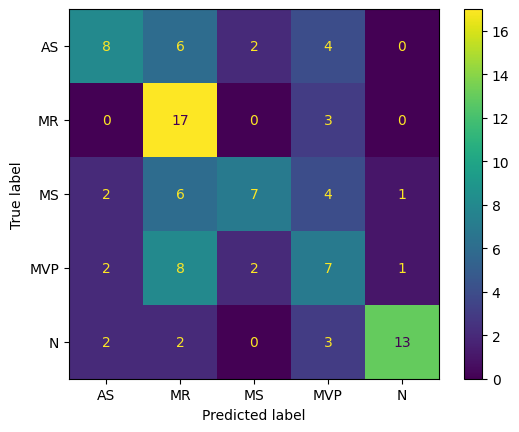

Accuracy : [0.82 0.75 0.83 0.73 0.91] mean:  0.808
Precision : [0.57142857 0.43589744 0.63636364 0.33333333 0.86666667] mean:  0.5687379287379286
Sensitivity : [0.4  0.85 0.35 0.35 0.65] mean:  0.52
Specificity : [0.925 0.725 0.95  0.825 0.975] mean:  0.8799999999999999
f1_score: [0.47058824 0.57627119 0.4516129  0.34146341 0.74285714] mean:  0.5165585764903783



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb2L10.csv_5.h5
4/4 [==============================] - 0s 2ms/step


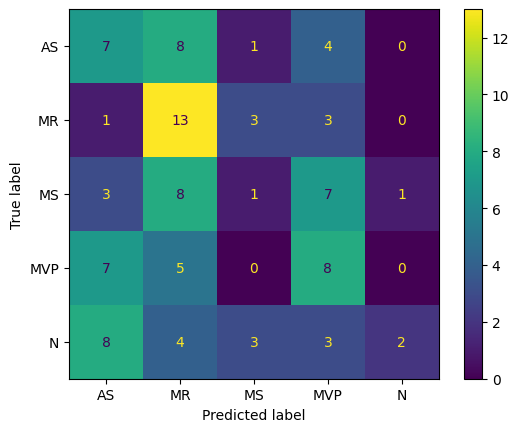

Accuracy : [0.68 0.68 0.74 0.71 0.81] mean:  0.724
Precision : [0.26923077 0.34210526 0.125      0.32       0.66666667] mean:  0.34460053981106614
Sensitivity : [0.35 0.65 0.05 0.4  0.1 ] mean:  0.31000000000000005
Specificity : [0.7625 0.6875 0.9125 0.7875 0.9875] mean:  0.8275
f1_score: [0.30434783 0.44827586 0.07142857 0.35555556 0.17391304] mean:  0.270704171723662



Accuracy All : [0.9399999999999998, 0.976, 0.9359999999999999, 0.944, 0.9280000000000002, 0.9279999999999999, 0.892, 0.836, 0.808, 0.724]
Precision All : [0.8779845104185874, 0.9407070707070707, 0.8653086044390392, 0.885296574770259, 0.847157853040206, 0.8444842513808031, 0.7509848484848485, 0.6683193490973811, 0.5687379287379286, 0.34460053981106614]
Sensitivity All : [0.85, 0.9400000000000001, 0.8400000000000001, 0.86, 0.8200000000000001, 0.82, 0.73, 0.5900000000000001, 0.52, 0.31000000000000005]
Specificity All : [0.9625, 0.985, 0.96, 0.9650000000000001, 0.9550000000000001, 0.9550000000000001, 0.9324999999999999, 0

In [107]:
testingVHD(a2, 2)

Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb3L1.csv_3.h5
4/4 [==============================] - 0s 2ms/step


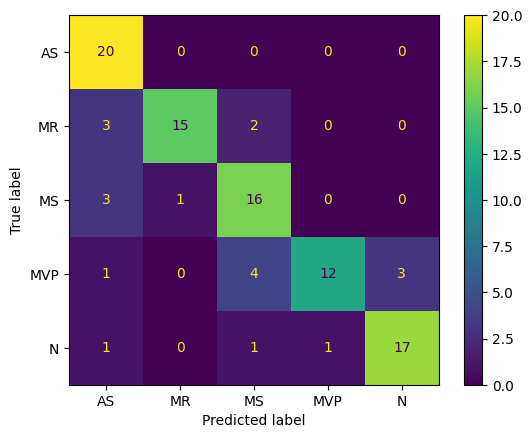

Accuracy : [0.92 0.94 0.89 0.91 0.94] mean:  0.9199999999999999
Precision : [0.71428571 0.9375     0.69565217 0.92307692 0.85      ] mean:  0.8241029622551361
Sensitivity : [1.   0.75 0.8  0.6  0.85] mean:  0.8
Specificity : [0.9    0.9875 0.9125 0.9875 0.9625] mean:  0.9500000000000002
f1_score: [0.83333333 0.83333333 0.74418605 0.72727273 0.85      ] mean:  0.7976250880902044



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb3L2.csv_5.h5
4/4 [==============================] - 0s 2ms/step


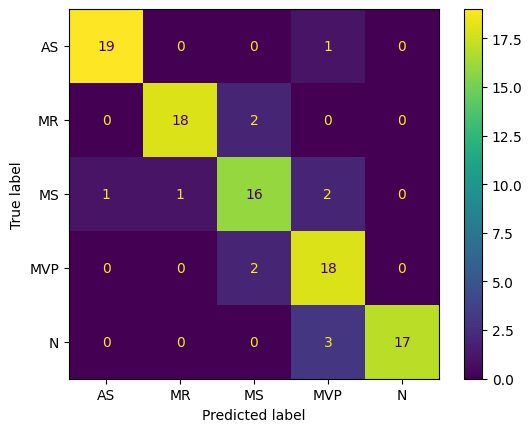

Accuracy : [0.98 0.97 0.92 0.92 0.97] mean:  0.952
Precision : [0.95       0.94736842 0.8        0.75       1.        ] mean:  0.8894736842105264
Sensitivity : [0.95 0.9  0.8  0.9  0.85] mean:  0.8800000000000001
Specificity : [0.9875 0.9875 0.95   0.925  1.    ] mean:  0.97
f1_score: [0.95       0.92307692 0.8        0.81818182 0.91891892] mean:  0.8820355320355322



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb3L3.csv_5.h5
4/4 [==============================] - 0s 3ms/step


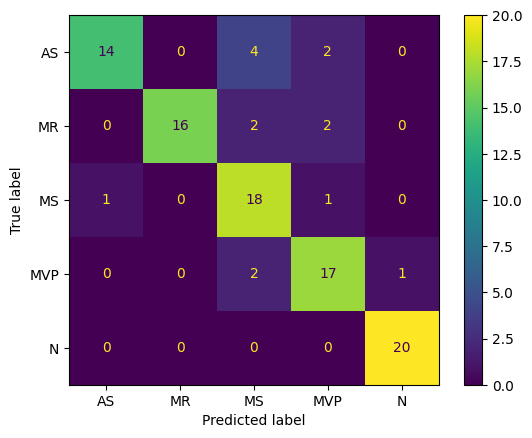

Accuracy : [0.93 0.96 0.9  0.92 0.99] mean:  0.9400000000000001
Precision : [0.93333333 1.         0.69230769 0.77272727 0.95238095] mean:  0.8701498501498502
Sensitivity : [0.7  0.8  0.9  0.85 1.  ] mean:  0.85
Specificity : [0.9875 1.     0.9    0.9375 0.9875] mean:  0.9625
f1_score: [0.8        0.88888889 0.7826087  0.80952381 0.97560976] mean:  0.8513262300324866



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb3L4.csv_5.h5
4/4 [==============================] - 0s 2ms/step


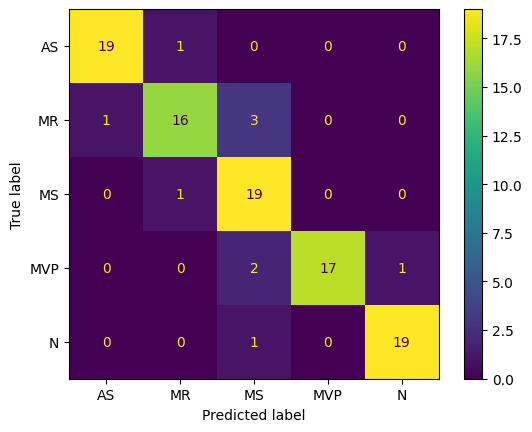

Accuracy : [0.98 0.94 0.93 0.97 0.98] mean:  0.9600000000000002
Precision : [0.95       0.88888889 0.76       1.         0.95      ] mean:  0.9097777777777777
Sensitivity : [0.95 0.8  0.95 0.85 0.95] mean:  0.9
Specificity : [0.9875 0.975  0.925  1.     0.9875] mean:  0.975
f1_score: [0.95       0.84210526 0.84444444 0.91891892 0.95      ] mean:  0.9010937253042517



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb3L5.csv_3.h5
4/4 [==============================] - 0s 2ms/step


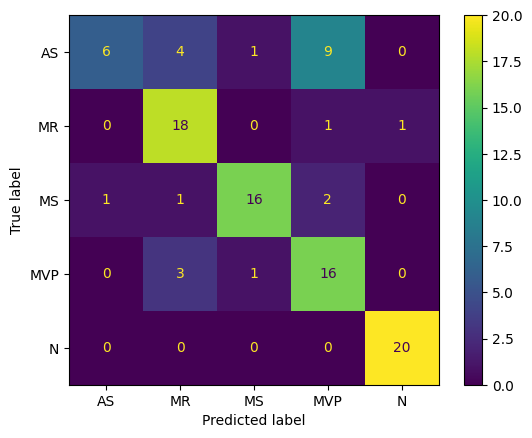

Accuracy : [0.85 0.9  0.94 0.84 0.99] mean:  0.9039999999999999
Precision : [0.85714286 0.69230769 0.88888889 0.57142857 0.95238095] mean:  0.7924297924297925
Sensitivity : [0.3 0.9 0.8 0.8 1. ] mean:  0.76
Specificity : [0.9875 0.9    0.975  0.85   0.9875] mean:  0.9400000000000001
f1_score: [0.44444444 0.7826087  0.84210526 0.66666667 0.97560976] mean:  0.7422869652037482



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb3L6.csv_2.h5
4/4 [==============================] - 0s 2ms/step


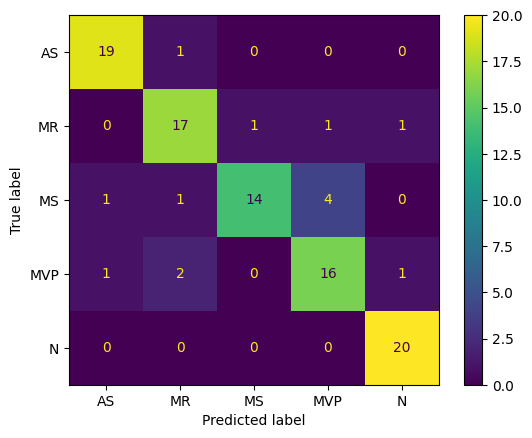

Accuracy : [0.97 0.93 0.93 0.91 0.98] mean:  0.9440000000000002
Precision : [0.9047619  0.80952381 0.93333333 0.76190476 0.90909091] mean:  0.8637229437229438
Sensitivity : [0.95 0.85 0.7  0.8  1.  ] mean:  0.86
Specificity : [0.975  0.95   0.9875 0.9375 0.975 ] mean:  0.9649999999999999
f1_score: [0.92682927 0.82926829 0.8        0.7804878  0.95238095] mean:  0.8577932636469223



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb3L7.csv_2.h5
4/4 [==============================] - 0s 2ms/step


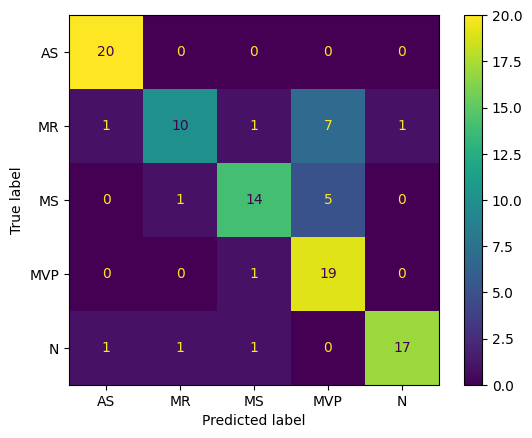

Accuracy : [0.98 0.88 0.91 0.87 0.96] mean:  0.9199999999999999
Precision : [0.90909091 0.83333333 0.82352941 0.61290323 0.94444444] mean:  0.8246602648879688
Sensitivity : [1.   0.5  0.7  0.95 0.85] mean:  0.8
Specificity : [0.975  0.975  0.9625 0.85   0.9875] mean:  0.95
f1_score: [0.95238095 0.625      0.75675676 0.74509804 0.89473684] mean:  0.7947945180917317



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb3L8.csv_5.h5
4/4 [==============================] - 0s 2ms/step


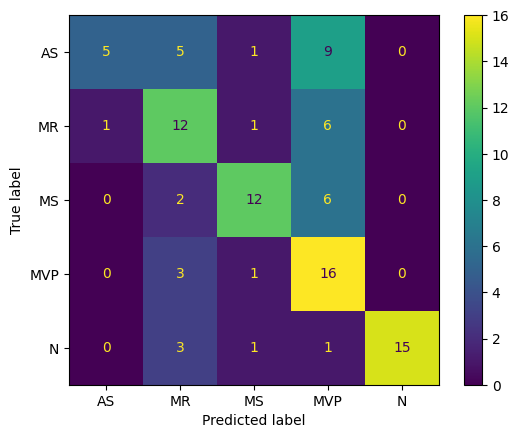

Accuracy : [0.84 0.79 0.88 0.74 0.95] mean:  0.8400000000000001
Precision : [0.83333333 0.48       0.75       0.42105263 1.        ] mean:  0.6968771929824562
Sensitivity : [0.25 0.6  0.6  0.8  0.75] mean:  0.6
Specificity : [0.9875 0.8375 0.95   0.725  1.    ] mean:  0.9
f1_score: [0.38461538 0.53333333 0.66666667 0.55172414 0.85714286] mean:  0.5986964759378552



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb3L9.csv_2.h5
4/4 [==============================] - 0s 2ms/step


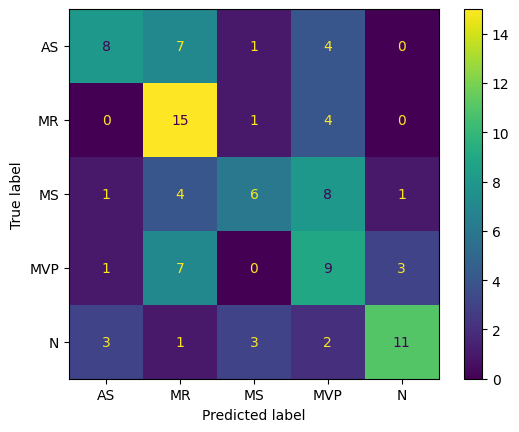

Accuracy : [0.83 0.76 0.81 0.71 0.87] mean:  0.796
Precision : [0.61538462 0.44117647 0.54545455 0.33333333 0.73333333] mean:  0.5337364596188126
Sensitivity : [0.4  0.75 0.3  0.45 0.55] mean:  0.49000000000000005
Specificity : [0.9375 0.7625 0.9375 0.775  0.95  ] mean:  0.8724999999999999
f1_score: [0.48484848 0.55555556 0.38709677 0.38297872 0.62857143] mean:  0.48781019331465447



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb3L10.csv_2.h5
4/4 [==============================] - 0s 2ms/step


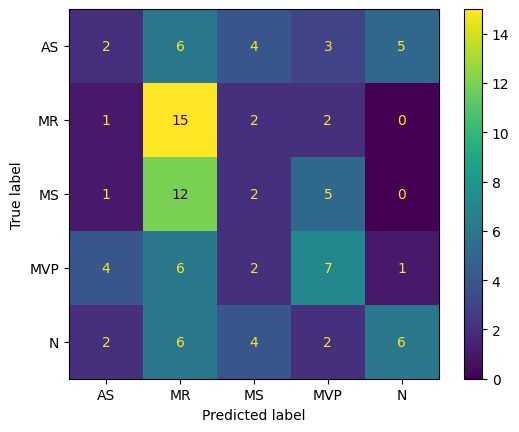

Accuracy : [0.74 0.65 0.7  0.75 0.8 ] mean:  0.728
Precision : [0.2        0.33333333 0.14285714 0.36842105 0.5       ] mean:  0.30892230576441104
Sensitivity : [0.1  0.75 0.1  0.35 0.3 ] mean:  0.31999999999999995
Specificity : [0.9   0.625 0.85  0.85  0.925] mean:  0.8300000000000001
f1_score: [0.13333333 0.46153846 0.11764706 0.35897436 0.375     ] mean:  0.28929864253393667



Accuracy All : [0.9199999999999999, 0.952, 0.9400000000000001, 0.9600000000000002, 0.9039999999999999, 0.9440000000000002, 0.9199999999999999, 0.8400000000000001, 0.796, 0.728]
Precision All : [0.8241029622551361, 0.8894736842105264, 0.8701498501498502, 0.9097777777777777, 0.7924297924297925, 0.8637229437229438, 0.8246602648879688, 0.6968771929824562, 0.5337364596188126, 0.30892230576441104]
Sensitivity All : [0.8, 0.8800000000000001, 0.85, 0.9, 0.76, 0.86, 0.8, 0.6, 0.49000000000000005, 0.31999999999999995]
Specificity All : [0.9500000000000002, 0.97, 0.9625, 0.975, 0.9400000000000001, 0.9649999999999999, 0.

In [108]:
testingVHD(a3, 3)

Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb4L1.csv_2.h5
4/4 [==============================] - 0s 3ms/step


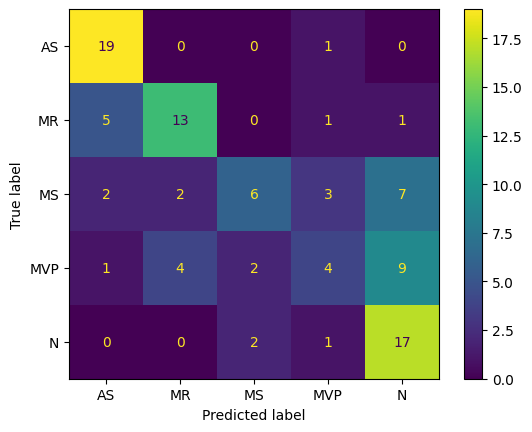

Accuracy : [0.91 0.87 0.82 0.78 0.8 ] mean:  0.836
Precision : [0.7037037  0.68421053 0.6        0.4        0.5       ] mean:  0.5775828460038986
Sensitivity : [0.95 0.65 0.3  0.2  0.85] mean:  0.5900000000000001
Specificity : [0.9    0.925  0.95   0.925  0.7875] mean:  0.8975
f1_score: [0.80851064 0.66666667 0.4        0.26666667 0.62962963] mean:  0.5542947202521671



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb4L2.csv_3.h5
4/4 [==============================] - 0s 2ms/step


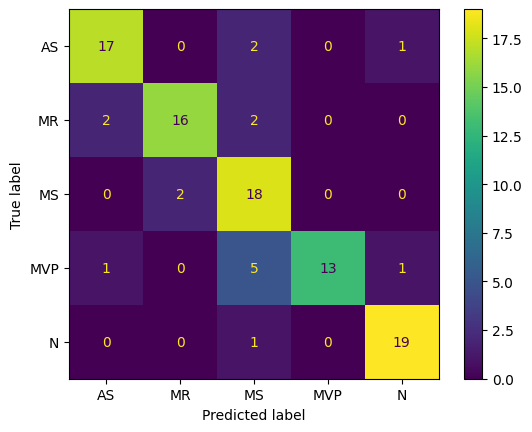

Accuracy : [0.94 0.94 0.88 0.93 0.97] mean:  0.932
Precision : [0.85       0.88888889 0.64285714 1.         0.9047619 ] mean:  0.8573015873015872
Sensitivity : [0.85 0.8  0.9  0.65 0.95] mean:  0.8299999999999998
Specificity : [0.9625 0.975  0.875  1.     0.975 ] mean:  0.9574999999999999
f1_score: [0.85       0.84210526 0.75       0.78787879 0.92682927] mean:  0.8313626638658732



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb4L3.csv_2.h5
4/4 [==============================] - 0s 2ms/step


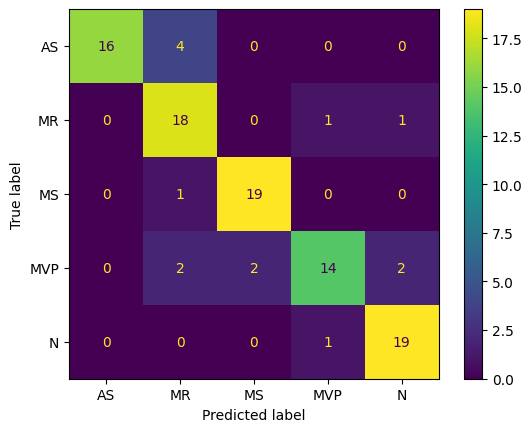

Accuracy : [0.96 0.91 0.97 0.92 0.96] mean:  0.944
Precision : [1.         0.72       0.9047619  0.875      0.86363636] mean:  0.8726796536796536
Sensitivity : [0.8  0.9  0.95 0.7  0.95] mean:  0.8600000000000001
Specificity : [1.     0.9125 0.975  0.975  0.9625] mean:  0.9650000000000001
f1_score: [0.88888889 0.8        0.92682927 0.77777778 0.9047619 ] mean:  0.8596515679442509



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb4L4.csv_2.h5
4/4 [==============================] - 0s 2ms/step


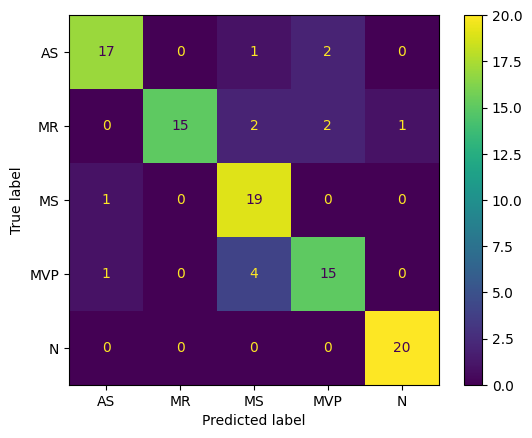

Accuracy : [0.95 0.95 0.92 0.91 0.99] mean:  0.944
Precision : [0.89473684 1.         0.73076923 0.78947368 0.95238095] mean:  0.8734721418931946
Sensitivity : [0.85 0.75 0.95 0.75 1.  ] mean:  0.86
Specificity : [0.975  1.     0.9125 0.95   0.9875] mean:  0.9650000000000001
f1_score: [0.87179487 0.85714286 0.82608696 0.76923077 0.97560976] mean:  0.8599730421575597



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb4L5.csv_2.h5
4/4 [==============================] - 0s 2ms/step


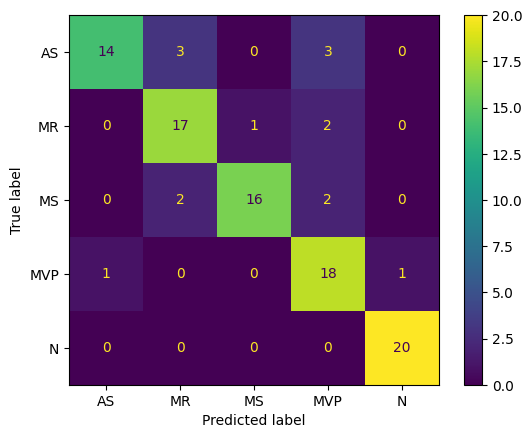

Accuracy : [0.93 0.92 0.95 0.91 0.99] mean:  0.9400000000000001
Precision : [0.93333333 0.77272727 0.94117647 0.72       0.95238095] mean:  0.8639236058059587
Sensitivity : [0.7  0.85 0.8  0.9  1.  ] mean:  0.85
Specificity : [0.9875 0.9375 0.9875 0.9125 0.9875] mean:  0.9625
f1_score: [0.8        0.80952381 0.86486486 0.8        0.97560976] mean:  0.849999686097247



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb4L6.csv_3.h5
4/4 [==============================] - 0s 2ms/step


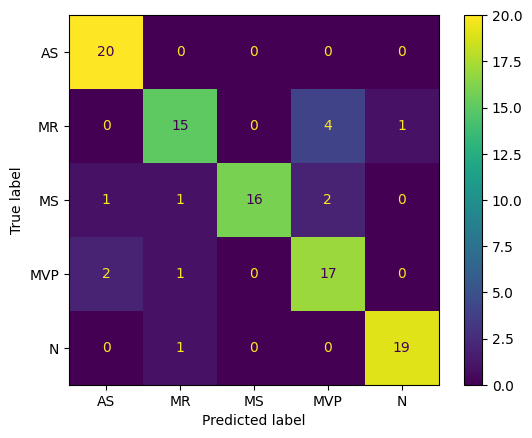

Accuracy : [0.97 0.92 0.96 0.91 0.98] mean:  0.9480000000000001
Precision : [0.86956522 0.83333333 1.         0.73913043 0.95      ] mean:  0.8784057971014493
Sensitivity : [1.   0.75 0.8  0.85 0.95] mean:  0.8699999999999999
Specificity : [0.9625 0.9625 1.     0.925  0.9875] mean:  0.9674999999999999
f1_score: [0.93023256 0.78947368 0.88888889 0.79069767 0.95      ] mean:  0.869858561131511



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb4L7.csv_5.h5
4/4 [==============================] - 0s 2ms/step


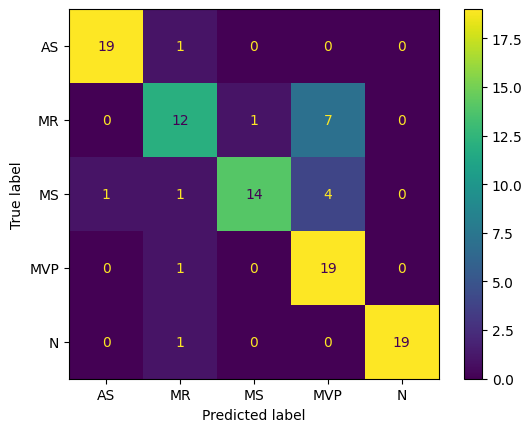

Accuracy : [0.98 0.88 0.93 0.88 0.99] mean:  0.932
Precision : [0.95       0.75       0.93333333 0.63333333 1.        ] mean:  0.8533333333333333
Sensitivity : [0.95 0.6  0.7  0.95 0.95] mean:  0.8300000000000001
Specificity : [0.9875 0.95   0.9875 0.8625 1.    ] mean:  0.9574999999999999
f1_score: [0.95       0.66666667 0.8        0.76       0.97435897] mean:  0.8302051282051283



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb4L8.csv_2.h5
4/4 [==============================] - 0s 2ms/step


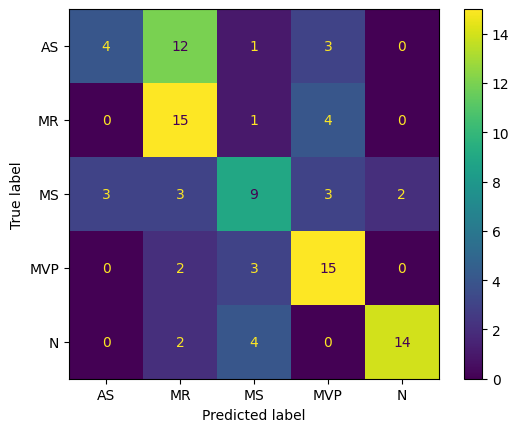

Accuracy : [0.81 0.76 0.8  0.85 0.92] mean:  0.8280000000000001
Precision : [0.57142857 0.44117647 0.5        0.6        0.875     ] mean:  0.5975210084033613
Sensitivity : [0.2  0.75 0.45 0.75 0.7 ] mean:  0.57
Specificity : [0.9625 0.7625 0.8875 0.875  0.975 ] mean:  0.8924999999999998
f1_score: [0.2962963  0.55555556 0.47368421 0.66666667 0.77777778] mean:  0.5539961013645224



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb4L9.csv_5.h5
4/4 [==============================] - 0s 2ms/step


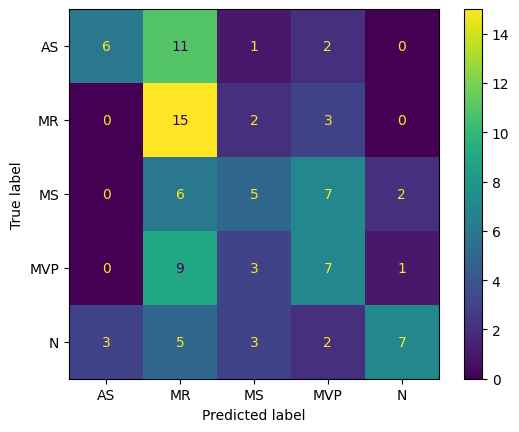

Accuracy : [0.83 0.64 0.76 0.73 0.84] mean:  0.76
Precision : [0.66666667 0.32608696 0.35714286 0.33333333 0.7       ] mean:  0.47664596273291926
Sensitivity : [0.3  0.75 0.25 0.35 0.35] mean:  0.4
Specificity : [0.9625 0.6125 0.8875 0.825  0.9625] mean:  0.8500000000000002
f1_score: [0.4137931  0.45454545 0.29411765 0.34146341 0.46666667] mean:  0.39411725727067337



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb4L10.csv_4.h5
4/4 [==============================] - 0s 2ms/step


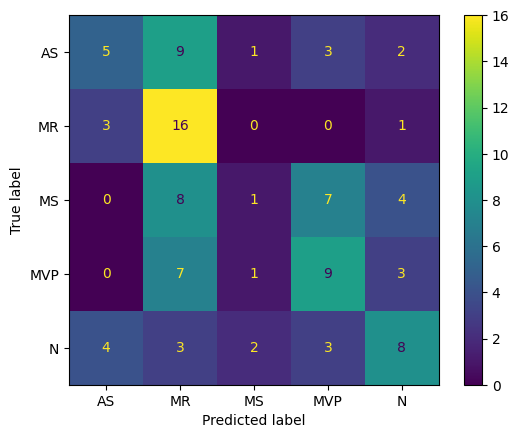

Accuracy : [0.78 0.69 0.77 0.76 0.78] mean:  0.756
Precision : [0.41666667 0.37209302 0.2        0.40909091 0.44444444] mean:  0.36845900869156684
Sensitivity : [0.25 0.8  0.05 0.45 0.4 ] mean:  0.39
Specificity : [0.9125 0.6625 0.95   0.8375 0.875 ] mean:  0.8474999999999999
f1_score: [0.3125     0.50793651 0.08       0.42857143 0.42105263] mean:  0.3500121136173768



Accuracy All : [0.836, 0.932, 0.944, 0.944, 0.9400000000000001, 0.9480000000000001, 0.932, 0.8280000000000001, 0.76, 0.756]
Precision All : [0.5775828460038986, 0.8573015873015872, 0.8726796536796536, 0.8734721418931946, 0.8639236058059587, 0.8784057971014493, 0.8533333333333333, 0.5975210084033613, 0.47664596273291926, 0.36845900869156684]
Sensitivity All : [0.5900000000000001, 0.8299999999999998, 0.8600000000000001, 0.86, 0.85, 0.8699999999999999, 0.8300000000000001, 0.57, 0.4, 0.39]
Specificity All : [0.8975, 0.9574999999999999, 0.9650000000000001, 0.9650000000000001, 0.9625, 0.9674999999999999, 0.9574999999999999, 0

In [109]:
testingVHD(a4, 4)

Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb5L1.csv_2.h5
4/4 [==============================] - 0s 2ms/step


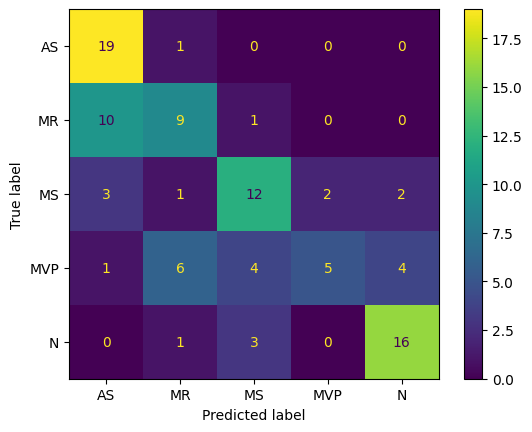

Accuracy : [0.85 0.8  0.84 0.83 0.9 ] mean:  0.844
Precision : [0.57575758 0.5        0.6        0.71428571 0.72727273] mean:  0.6234632034632035
Sensitivity : [0.95 0.45 0.6  0.25 0.8 ] mean:  0.61
Specificity : [0.825  0.8875 0.9    0.975  0.925 ] mean:  0.9025000000000001
f1_score: [0.71698113 0.47368421 0.6        0.37037037 0.76190476] mean:  0.5845880949753839



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb5L2.csv_4.h5
4/4 [==============================] - 0s 2ms/step


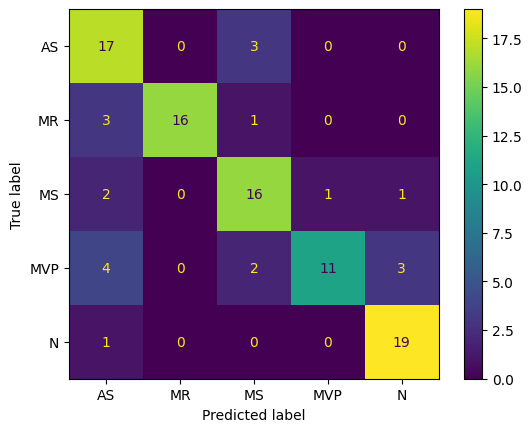

Accuracy : [0.87 0.96 0.9  0.9  0.95] mean:  0.916
Precision : [0.62962963 1.         0.72727273 0.91666667 0.82608696] mean:  0.8199311960181526
Sensitivity : [0.85 0.8  0.8  0.55 0.95] mean:  0.79
Specificity : [0.875  1.     0.925  0.9875 0.95  ] mean:  0.9475
f1_score: [0.72340426 0.88888889 0.76190476 0.6875     0.88372093] mean:  0.7890837672690717



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb5L3.csv_2.h5
4/4 [==============================] - 0s 2ms/step


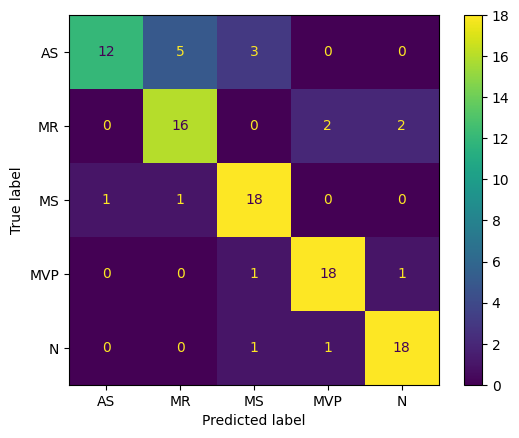

Accuracy : [0.91 0.9  0.93 0.95 0.95] mean:  0.9280000000000002
Precision : [0.92307692 0.72727273 0.7826087  0.85714286 0.85714286] mean:  0.8294488120575076
Sensitivity : [0.6 0.8 0.9 0.9 0.9] mean:  0.82
Specificity : [0.9875 0.925  0.9375 0.9625 0.9625] mean:  0.9550000000000001
f1_score: [0.72727273 0.76190476 0.8372093  0.87804878 0.87804878] mean:  0.816496870495736



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb5L4.csv_5.h5
4/4 [==============================] - 0s 2ms/step


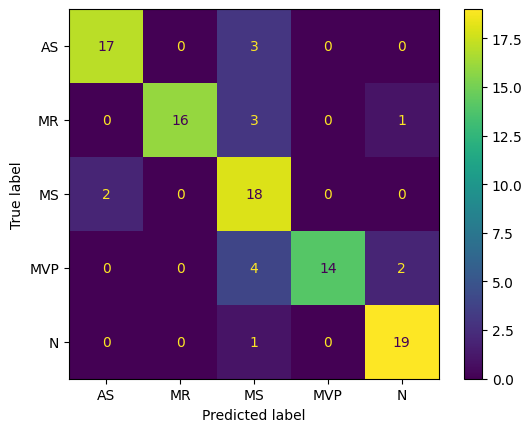

Accuracy : [0.95 0.96 0.87 0.94 0.96] mean:  0.9359999999999999
Precision : [0.89473684 1.         0.62068966 1.         0.86363636] mean:  0.8758125721828082
Sensitivity : [0.85 0.8  0.9  0.7  0.95] mean:  0.8400000000000001
Specificity : [0.975  1.     0.8625 1.     0.9625] mean:  0.9600000000000002
f1_score: [0.87179487 0.88888889 0.73469388 0.82352941 0.9047619 ] mean:  0.8447337909522783



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb5L5.csv_5.h5
4/4 [==============================] - 0s 2ms/step


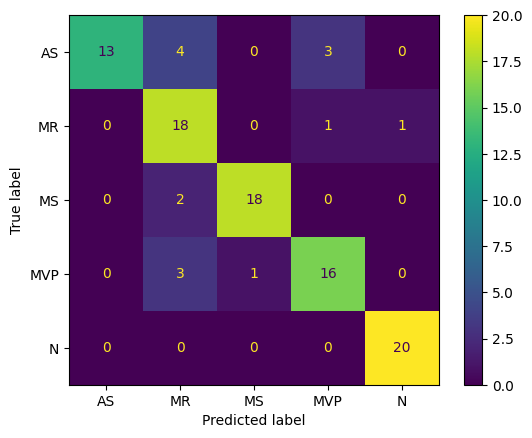

Accuracy : [0.93 0.89 0.97 0.92 0.99] mean:  0.9400000000000001
Precision : [1.         0.66666667 0.94736842 0.8        0.95238095] mean:  0.8732832080200501
Sensitivity : [0.65 0.9  0.9  0.8  1.  ] mean:  0.85
Specificity : [1.     0.8875 0.9875 0.95   0.9875] mean:  0.9625
f1_score: [0.78787879 0.76595745 0.92307692 0.8        0.97560976] mean:  0.8505045827723567



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb5L6.csv_2.h5
4/4 [==============================] - 0s 2ms/step


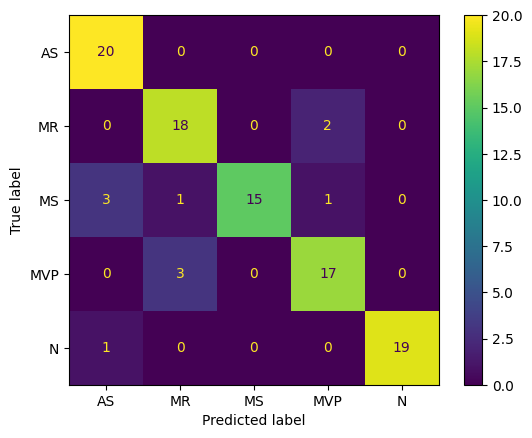

Accuracy : [0.96 0.94 0.95 0.94 0.99] mean:  0.9559999999999998
Precision : [0.83333333 0.81818182 1.         0.85       1.        ] mean:  0.9003030303030304
Sensitivity : [1.   0.9  0.75 0.85 0.95] mean:  0.89
Specificity : [0.95   0.95   1.     0.9625 1.    ] mean:  0.9724999999999999
f1_score: [0.90909091 0.85714286 0.85714286 0.85       0.97435897] mean:  0.8895471195471195



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb5L7.csv_2.h5
4/4 [==============================] - 0s 2ms/step


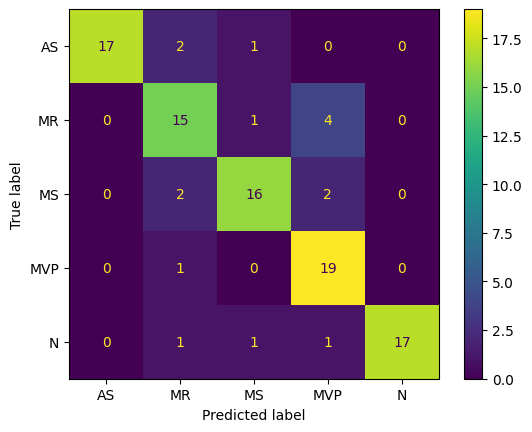

Accuracy : [0.97 0.89 0.93 0.92 0.97] mean:  0.9359999999999999
Precision : [1.         0.71428571 0.84210526 0.73076923 1.        ] mean:  0.857432041642568
Sensitivity : [0.85 0.75 0.8  0.95 0.85] mean:  0.8400000000000001
Specificity : [1.     0.925  0.9625 0.9125 1.    ] mean:  0.9600000000000002
f1_score: [0.91891892 0.73170732 0.82051282 0.82608696 0.91891892] mean:  0.8432289863891136



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb5L8.csv_3.h5
4/4 [==============================] - 0s 2ms/step


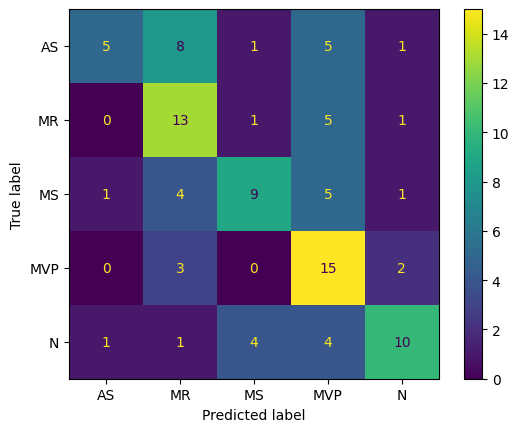

Accuracy : [0.83 0.77 0.83 0.76 0.85] mean:  0.808
Precision : [0.71428571 0.44827586 0.6        0.44117647 0.66666667] mean:  0.5740809427219162
Sensitivity : [0.25 0.65 0.45 0.75 0.5 ] mean:  0.52
Specificity : [0.975  0.8    0.925  0.7625 0.9375] mean:  0.8800000000000001
f1_score: [0.37037037 0.53061224 0.51428571 0.55555556 0.57142857] mean:  0.5084504913076342



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb5L9.csv_5.h5
4/4 [==============================] - 0s 2ms/step


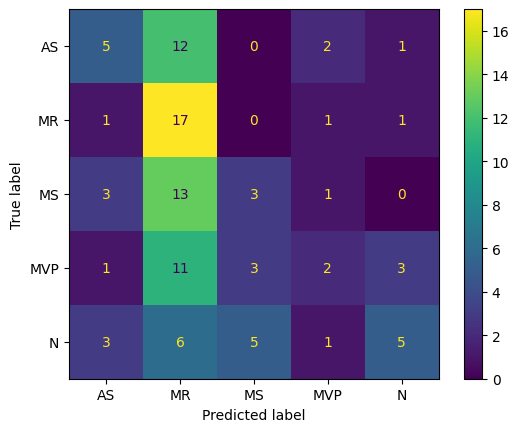

Accuracy : [0.77 0.55 0.75 0.77 0.8 ] mean:  0.7280000000000001
Precision : [0.38461538 0.28813559 0.27272727 0.28571429 0.5       ] mean:  0.34623850725545646
Sensitivity : [0.25 0.85 0.15 0.1  0.25] mean:  0.32
Specificity : [0.9    0.475  0.9    0.9375 0.9375] mean:  0.8300000000000001
f1_score: [0.3030303  0.43037975 0.19354839 0.14814815 0.33333333] mean:  0.2816879836888003



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb5L10.csv_1.h5
4/4 [==============================] - 0s 2ms/step


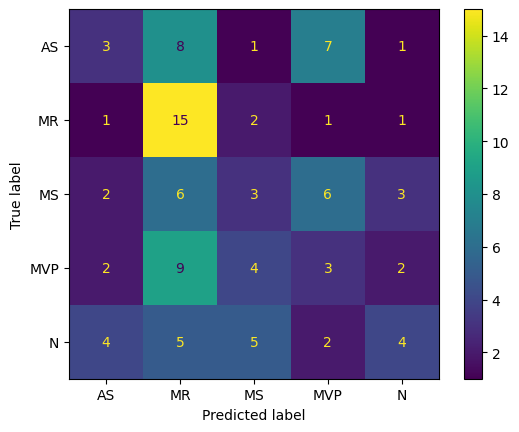

Accuracy : [0.74 0.67 0.71 0.67 0.77] mean:  0.712
Precision : [0.25       0.34883721 0.2        0.15789474 0.36363636] mean:  0.2640736619561589
Sensitivity : [0.15 0.75 0.15 0.15 0.2 ] mean:  0.27999999999999997
Specificity : [0.8875 0.65   0.85   0.8    0.9125] mean:  0.82
f1_score: [0.1875     0.47619048 0.17142857 0.15384615 0.25806452] mean:  0.24940594351884676



Accuracy All : [0.844, 0.916, 0.9280000000000002, 0.9359999999999999, 0.9400000000000001, 0.9559999999999998, 0.9359999999999999, 0.808, 0.7280000000000001, 0.712]
Precision All : [0.6234632034632035, 0.8199311960181526, 0.8294488120575076, 0.8758125721828082, 0.8732832080200501, 0.9003030303030304, 0.857432041642568, 0.5740809427219162, 0.34623850725545646, 0.2640736619561589]
Sensitivity All : [0.61, 0.79, 0.82, 0.8400000000000001, 0.85, 0.89, 0.8400000000000001, 0.52, 0.32, 0.27999999999999997]
Specificity All : [0.9025000000000001, 0.9475, 0.9550000000000001, 0.9600000000000002, 0.9625, 0.9724999999999999, 0.960000

In [110]:
testingVHD(a5, 5)

Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb6L1.csv_2.h5
4/4 [==============================] - 0s 2ms/step


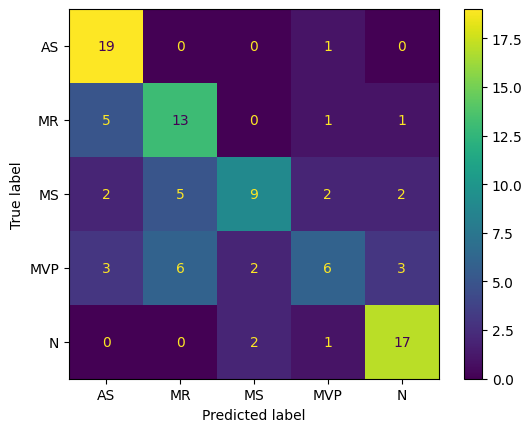

Accuracy : [0.89 0.82 0.85 0.81 0.91] mean:  0.8560000000000001
Precision : [0.65517241 0.54166667 0.69230769 0.54545455 0.73913043] mean:  0.6347463506009232
Sensitivity : [0.95 0.65 0.45 0.3  0.85] mean:  0.64
Specificity : [0.875  0.8625 0.95   0.9375 0.925 ] mean:  0.9099999999999999
f1_score: [0.7755102  0.59090909 0.54545455 0.38709677 0.79069767] mean:  0.6179336578114845



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb6L2.csv_5.h5
4/4 [==============================] - 0s 5ms/step


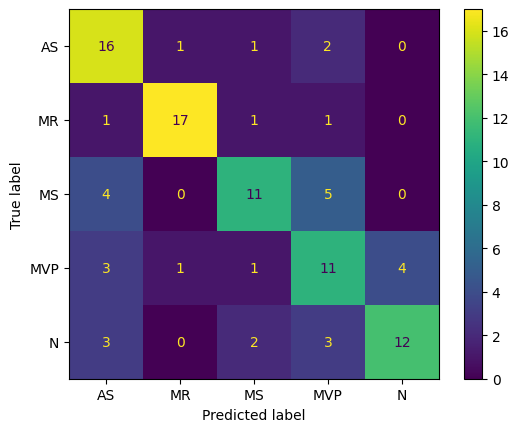

Accuracy : [0.85 0.95 0.86 0.8  0.88] mean:  0.868
Precision : [0.59259259 0.89473684 0.6875     0.5        0.75      ] mean:  0.6849658869395712
Sensitivity : [0.8  0.85 0.55 0.55 0.6 ] mean:  0.67
Specificity : [0.8625 0.975  0.9375 0.8625 0.95  ] mean:  0.9175000000000001
f1_score: [0.68085106 0.87179487 0.61111111 0.52380952 0.66666667] mean:  0.6708466474423921



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb6L3.csv_5.h5
4/4 [==============================] - 0s 2ms/step


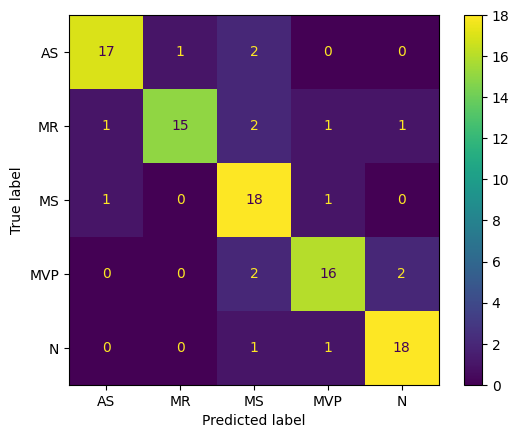

Accuracy : [0.95 0.94 0.91 0.93 0.95] mean:  0.9359999999999999
Precision : [0.89473684 0.9375     0.72       0.84210526 0.85714286] mean:  0.8502969924812029
Sensitivity : [0.85 0.75 0.9  0.8  0.9 ] mean:  0.8400000000000001
Specificity : [0.975  0.9875 0.9125 0.9625 0.9625] mean:  0.96
f1_score: [0.87179487 0.83333333 0.8        0.82051282 0.87804878] mean:  0.840737961225766



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb6L4.csv_2.h5
4/4 [==============================] - 0s 2ms/step


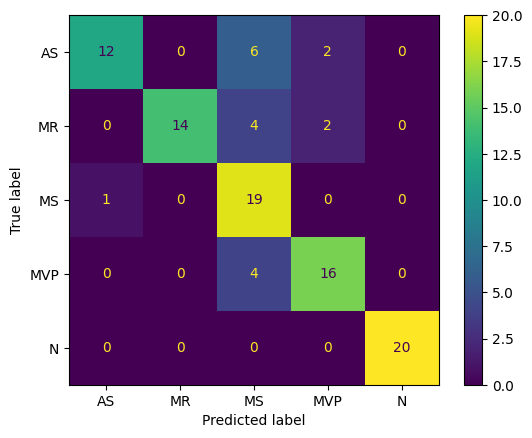

Accuracy : [0.91 0.94 0.85 0.92 1.  ] mean:  0.924
Precision : [0.92307692 1.         0.57575758 0.8        1.        ] mean:  0.8597668997668999
Sensitivity : [0.6  0.7  0.95 0.8  1.  ] mean:  0.8099999999999999
Specificity : [0.9875 1.     0.825  0.95   1.    ] mean:  0.9525
f1_score: [0.72727273 0.82352941 0.71698113 0.8        1.        ] mean:  0.8135566542225809



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb6L5.csv_3.h5
4/4 [==============================] - 0s 2ms/step


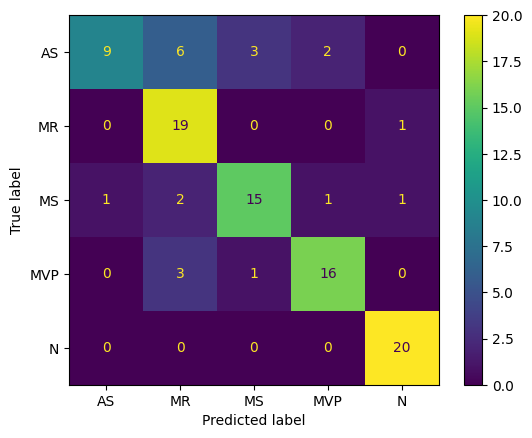

Accuracy : [0.88 0.88 0.91 0.93 0.98] mean:  0.916
Precision : [0.9        0.63333333 0.78947368 0.84210526 0.90909091] mean:  0.8148006379585327
Sensitivity : [0.45 0.95 0.75 0.8  1.  ] mean:  0.79
Specificity : [0.9875 0.8625 0.95   0.9625 0.975 ] mean:  0.9475
f1_score: [0.6        0.76       0.76923077 0.82051282 0.95238095] mean:  0.7804249084249084



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb6L6.csv_2.h5
4/4 [==============================] - 0s 2ms/step


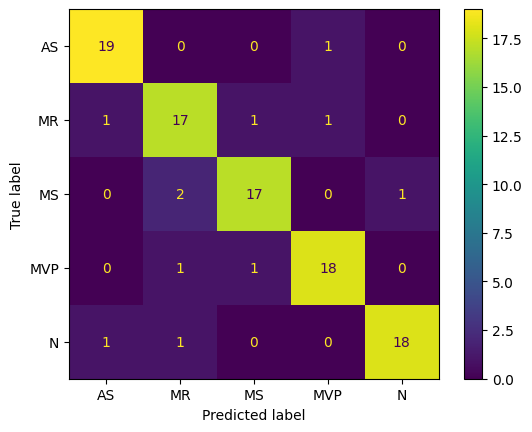

Accuracy : [0.97 0.93 0.95 0.96 0.97] mean:  0.9559999999999998
Precision : [0.9047619  0.80952381 0.89473684 0.9        0.94736842] mean:  0.8912781954887219
Sensitivity : [0.95 0.85 0.85 0.9  0.9 ] mean:  0.89
Specificity : [0.975  0.95   0.975  0.975  0.9875] mean:  0.9724999999999999
f1_score: [0.92682927 0.82926829 0.87179487 0.9        0.92307692] mean:  0.8901938711694809



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb6L7.csv_3.h5
4/4 [==============================] - 0s 2ms/step


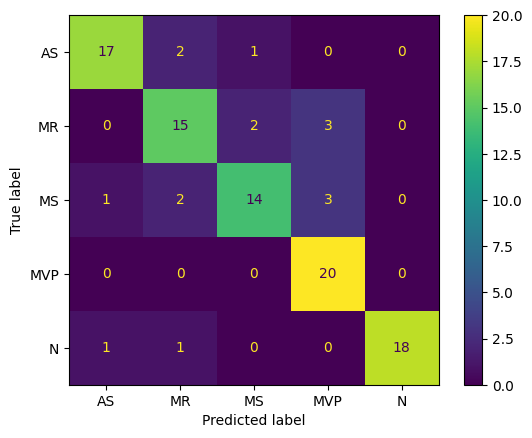

Accuracy : [0.95 0.9  0.91 0.94 0.98] mean:  0.9359999999999999
Precision : [0.89473684 0.75       0.82352941 0.76923077 1.        ] mean:  0.8474994046201477
Sensitivity : [0.85 0.75 0.7  1.   0.9 ] mean:  0.8400000000000001
Specificity : [0.975  0.9375 0.9625 0.925  1.    ] mean:  0.96
f1_score: [0.87179487 0.75       0.75675676 0.86956522 0.94736842] mean:  0.839097053399113



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb6L8.csv_5.h5
4/4 [==============================] - 0s 4ms/step


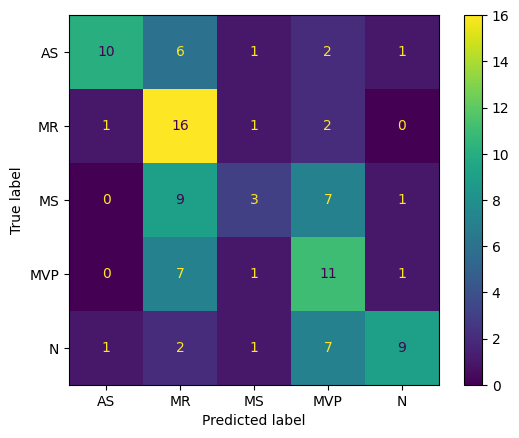

Accuracy : [0.88 0.72 0.79 0.73 0.86] mean:  0.796
Precision : [0.83333333 0.4        0.42857143 0.37931034 0.75      ] mean:  0.5582430213464696
Sensitivity : [0.5  0.8  0.15 0.55 0.45] mean:  0.49000000000000005
Specificity : [0.975  0.7    0.95   0.775  0.9625] mean:  0.8724999999999999
f1_score: [0.625      0.53333333 0.22222222 0.44897959 0.5625    ] mean:  0.47840702947845803



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb6L9.csv_2.h5
4/4 [==============================] - 0s 2ms/step


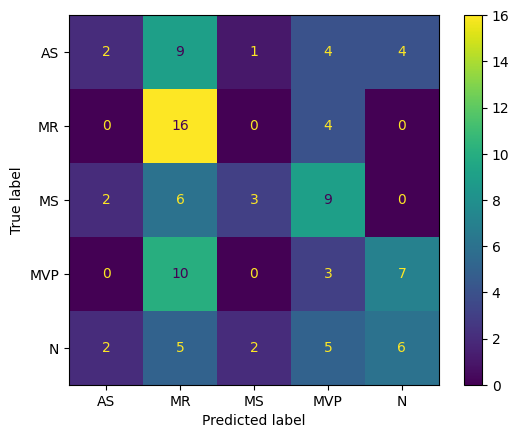

Accuracy : [0.78 0.66 0.8  0.61 0.75] mean:  0.72
Precision : [0.33333333 0.34782609 0.5        0.12       0.35294118] mean:  0.33082011935208866
Sensitivity : [0.1  0.8  0.15 0.15 0.3 ] mean:  0.3
Specificity : [0.95   0.625  0.9625 0.725  0.8625] mean:  0.825
f1_score: [0.15384615 0.48484848 0.23076923 0.13333333 0.32432432] mean:  0.2654243054243054



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb6L10.csv_4.h5
4/4 [==============================] - 0s 2ms/step


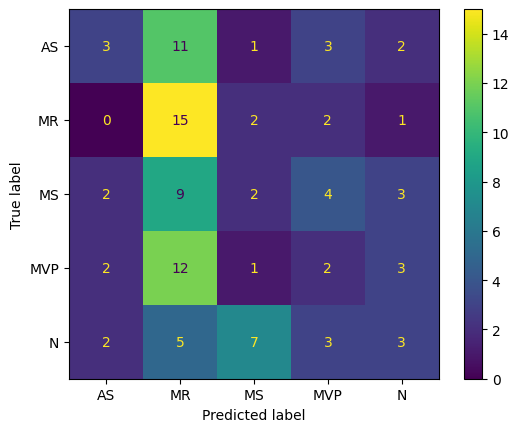

Accuracy : [0.77 0.58 0.71 0.7  0.74] mean:  0.7
Precision : [0.33333333 0.28846154 0.15384615 0.14285714 0.25      ] mean:  0.2336996336996337
Sensitivity : [0.15 0.75 0.1  0.1  0.15] mean:  0.25
Specificity : [0.925  0.5375 0.8625 0.85   0.8875] mean:  0.8125
f1_score: [0.20689655 0.41666667 0.12121212 0.11764706 0.1875    ] mean:  0.20998447968529105



Accuracy All : [0.8560000000000001, 0.868, 0.9359999999999999, 0.924, 0.916, 0.9559999999999998, 0.9359999999999999, 0.796, 0.72, 0.7]
Precision All : [0.6347463506009232, 0.6849658869395712, 0.8502969924812029, 0.8597668997668999, 0.8148006379585327, 0.8912781954887219, 0.8474994046201477, 0.5582430213464696, 0.33082011935208866, 0.2336996336996337]
Sensitivity All : [0.64, 0.67, 0.8400000000000001, 0.8099999999999999, 0.79, 0.89, 0.8400000000000001, 0.49000000000000005, 0.3, 0.25]
Specificity All : [0.9099999999999999, 0.9175000000000001, 0.96, 0.9525, 0.9475, 0.9724999999999999, 0.96, 0.8724999999999999, 0.825, 0.8125]
f1_score Al

In [111]:
testingVHD(a6, 6)

Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb7L1.csv_2.h5
4/4 [==============================] - 0s 3ms/step


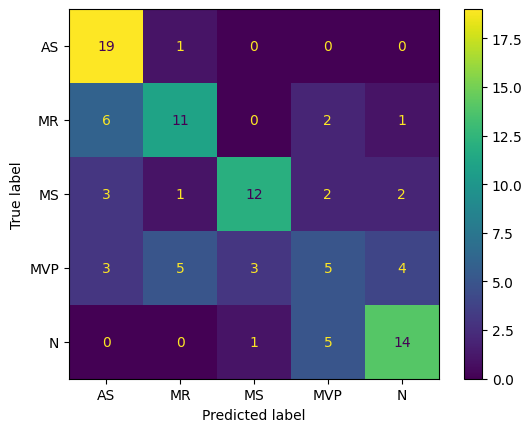

Accuracy : [0.87 0.84 0.88 0.76 0.87] mean:  0.844
Precision : [0.61290323 0.61111111 0.75       0.35714286 0.66666667] mean:  0.5995647721454173
Sensitivity : [0.95 0.55 0.6  0.25 0.7 ] mean:  0.61
Specificity : [0.85   0.9125 0.95   0.8875 0.9125] mean:  0.9024999999999999
f1_score: [0.74509804 0.57894737 0.66666667 0.29411765 0.68292683] mean:  0.5935513101261043



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb7L2.csv_2.h5
4/4 [==============================] - 0s 2ms/step


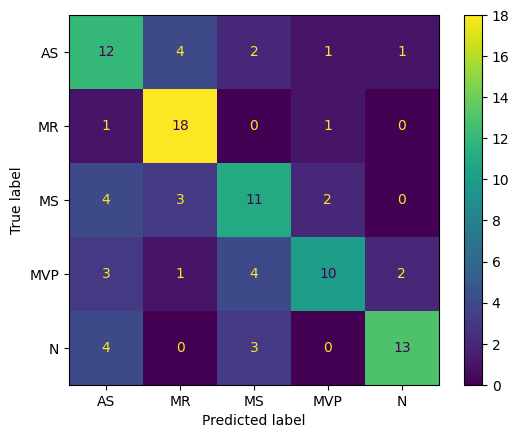

Accuracy : [0.8  0.9  0.82 0.86 0.9 ] mean:  0.8560000000000001
Precision : [0.5        0.69230769 0.55       0.71428571 0.8125    ] mean:  0.6538186813186814
Sensitivity : [0.6  0.9  0.55 0.5  0.65] mean:  0.6399999999999999
Specificity : [0.85   0.9    0.8875 0.95   0.9625] mean:  0.9100000000000001
f1_score: [0.54545455 0.7826087  0.55       0.58823529 0.72222222] mean:  0.6377041514893177



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb7L3.csv_3.h5
4/4 [==============================] - 0s 2ms/step


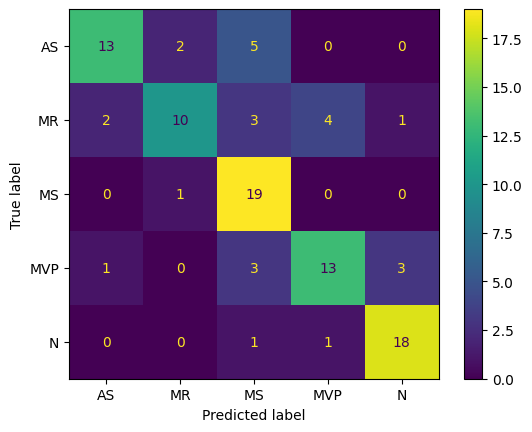

Accuracy : [0.9  0.87 0.87 0.88 0.94] mean:  0.892
Precision : [0.8125     0.76923077 0.61290323 0.72222222 0.81818182] mean:  0.7470076070882523
Sensitivity : [0.65 0.5  0.95 0.65 0.9 ] mean:  0.7299999999999999
Specificity : [0.9625 0.9625 0.85   0.9375 0.95  ] mean:  0.9324999999999999
f1_score: [0.72222222 0.60606061 0.74509804 0.68421053 0.85714286] mean:  0.7229468501914322



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb7L4.csv_5.h5
4/4 [==============================] - 0s 2ms/step


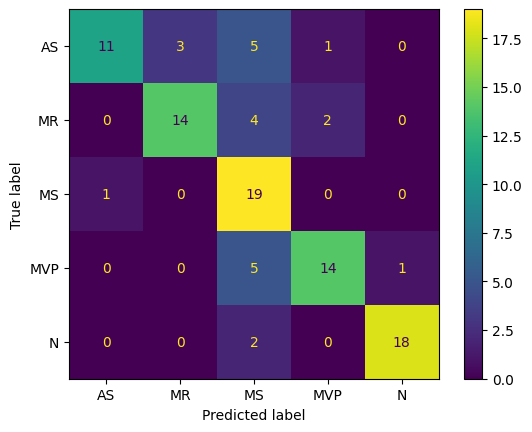

Accuracy : [0.9  0.91 0.83 0.91 0.97] mean:  0.9040000000000001
Precision : [0.91666667 0.82352941 0.54285714 0.82352941 0.94736842] mean:  0.8107902108211705
Sensitivity : [0.55 0.7  0.95 0.7  0.9 ] mean:  0.76
Specificity : [0.9875 0.9625 0.8    0.9625 0.9875] mean:  0.9400000000000001
f1_score: [0.6875     0.75675676 0.69090909 0.75675676 0.92307692] mean:  0.7629999054999054



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb7L5.csv_2.h5
4/4 [==============================] - 0s 2ms/step


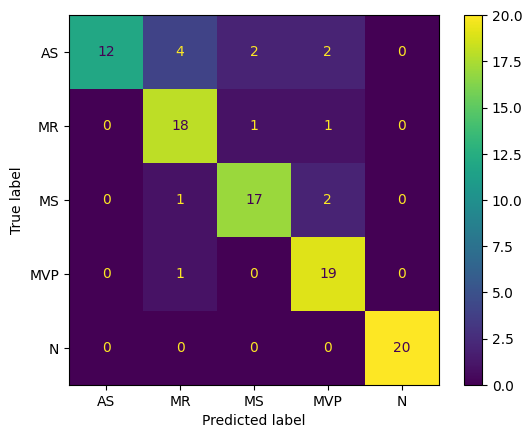

Accuracy : [0.92 0.92 0.94 0.94 1.  ] mean:  0.9440000000000002
Precision : [1.         0.75       0.85       0.79166667 1.        ] mean:  0.8783333333333333
Sensitivity : [0.6  0.9  0.85 0.95 1.  ] mean:  0.86
Specificity : [1.     0.925  0.9625 0.9375 1.    ] mean:  0.9650000000000001
f1_score: [0.75       0.81818182 0.85       0.86363636 1.        ] mean:  0.8563636363636362



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb7L6.csv_2.h5
4/4 [==============================] - 0s 2ms/step


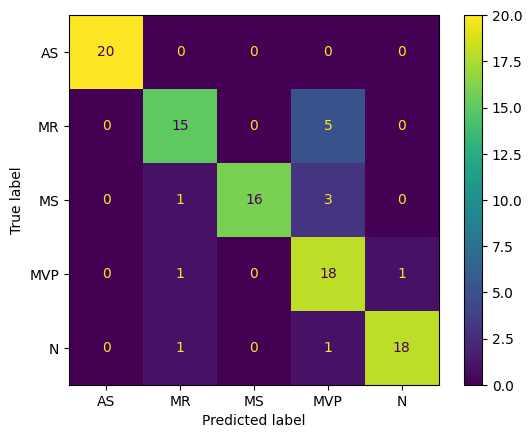

Accuracy : [1.   0.92 0.96 0.89 0.97] mean:  0.9480000000000001
Precision : [1.         0.83333333 1.         0.66666667 0.94736842] mean:  0.8894736842105264
Sensitivity : [1.   0.75 0.8  0.9  0.9 ] mean:  0.8699999999999999
Specificity : [1.     0.9625 1.     0.8875 0.9875] mean:  0.9674999999999999
f1_score: [1.         0.78947368 0.88888889 0.76595745 0.92307692] mean:  0.8734793885969697



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb7L7.csv_2.h5
4/4 [==============================] - 0s 2ms/step


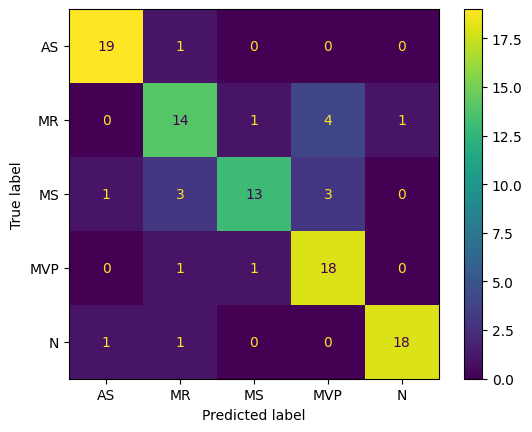

Accuracy : [0.97 0.88 0.91 0.91 0.97] mean:  0.9280000000000002
Precision : [0.9047619  0.7        0.86666667 0.72       0.94736842] mean:  0.8277593984962406
Sensitivity : [0.95 0.7  0.65 0.9  0.9 ] mean:  0.82
Specificity : [0.975  0.925  0.975  0.9125 0.9875] mean:  0.9550000000000001
f1_score: [0.92682927 0.7        0.74285714 0.8        0.92307692] mean:  0.8185526668453498



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb7L8.csv_1.h5
4/4 [==============================] - 0s 2ms/step


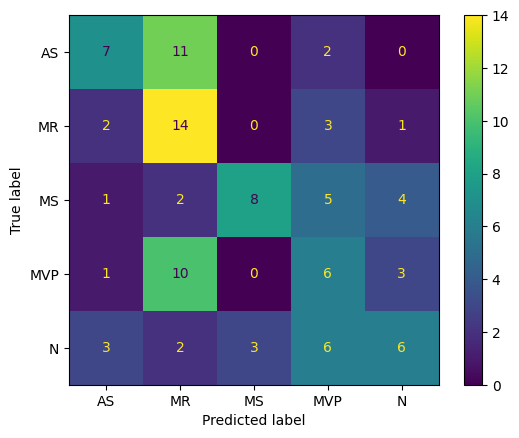

Accuracy : [0.8  0.69 0.85 0.7  0.78] mean:  0.764
Precision : [0.5        0.35897436 0.72727273 0.27272727 0.42857143] mean:  0.4575091575091575
Sensitivity : [0.35 0.7  0.4  0.3  0.3 ] mean:  0.41
Specificity : [0.9125 0.6875 0.9625 0.8    0.9   ] mean:  0.8525
f1_score: [0.41176471 0.47457627 0.51612903 0.28571429 0.35294118] mean:  0.4082250943023464



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb7L9.csv_2.h5
4/4 [==============================] - 0s 2ms/step


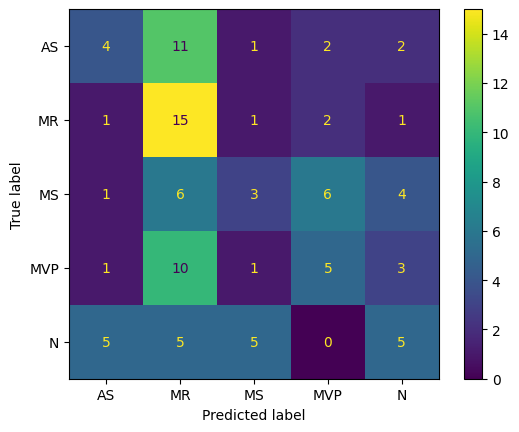

Accuracy : [0.76 0.63 0.75 0.75 0.75] mean:  0.728
Precision : [0.33333333 0.31914894 0.27272727 0.33333333 0.33333333] mean:  0.31837524177949705
Sensitivity : [0.2  0.75 0.15 0.25 0.25] mean:  0.31999999999999995
Specificity : [0.9   0.6   0.9   0.875 0.875] mean:  0.8300000000000001
f1_score: [0.25       0.44776119 0.19354839 0.28571429 0.28571429] mean:  0.2925476305110393



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb7L10.csv_4.h5
4/4 [==============================] - 0s 2ms/step


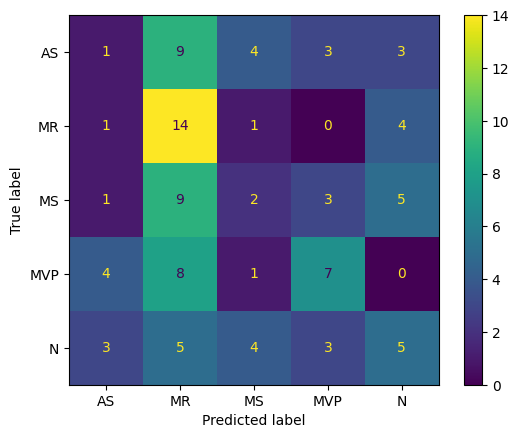

Accuracy : [0.72 0.63 0.72 0.78 0.73] mean:  0.7160000000000001
Precision : [0.1        0.31111111 0.16666667 0.4375     0.29411765] mean:  0.26187908496732026
Sensitivity : [0.05 0.7  0.1  0.35 0.25] mean:  0.29
Specificity : [0.8875 0.6125 0.875  0.8875 0.85  ] mean:  0.8225
f1_score: [0.06666667 0.43076923 0.125      0.38888889 0.27027027] mean:  0.2563190113190113



Accuracy All : [0.844, 0.8560000000000001, 0.892, 0.9040000000000001, 0.9440000000000002, 0.9480000000000001, 0.9280000000000002, 0.764, 0.728, 0.7160000000000001]
Precision All : [0.5995647721454173, 0.6538186813186814, 0.7470076070882523, 0.8107902108211705, 0.8783333333333333, 0.8894736842105264, 0.8277593984962406, 0.4575091575091575, 0.31837524177949705, 0.26187908496732026]
Sensitivity All : [0.61, 0.6399999999999999, 0.7299999999999999, 0.76, 0.86, 0.8699999999999999, 0.82, 0.41, 0.31999999999999995, 0.29]
Specificity All : [0.9024999999999999, 0.9100000000000001, 0.9324999999999999, 0.9400000000000001, 0.965000

In [112]:
testingVHD(a7, 7)

Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb8L1.csv_3.h5
4/4 [==============================] - 0s 2ms/step


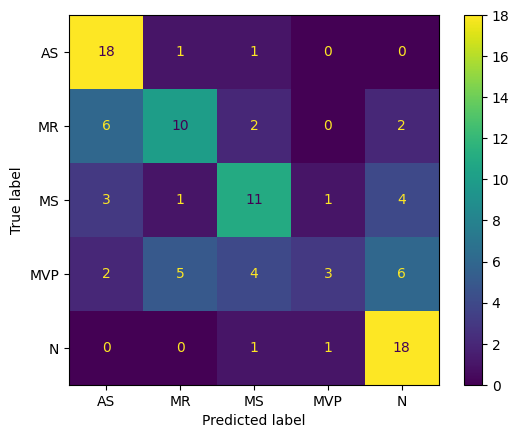

Accuracy : [0.87 0.83 0.83 0.81 0.86] mean:  0.8400000000000001
Precision : [0.62068966 0.58823529 0.57894737 0.6        0.6       ] mean:  0.5975744635422228
Sensitivity : [0.9  0.5  0.55 0.15 0.9 ] mean:  0.6
Specificity : [0.8625 0.9125 0.9    0.975  0.85  ] mean:  0.9
f1_score: [0.73469388 0.54054054 0.56410256 0.24       0.72      ] mean:  0.559867396438825



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb8L2.csv_2.h5
4/4 [==============================] - 0s 3ms/step


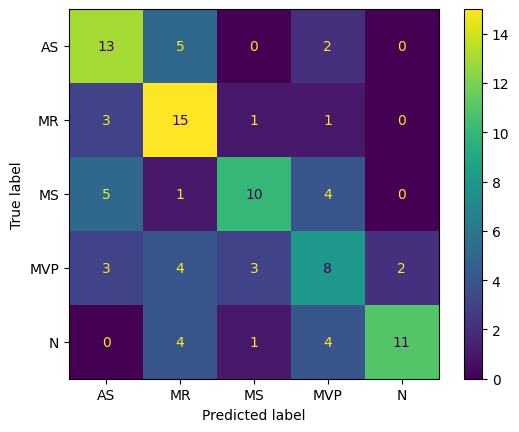

Accuracy : [0.82 0.81 0.85 0.77 0.89] mean:  0.828
Precision : [0.54166667 0.51724138 0.66666667 0.42105263 0.84615385] mean:  0.5985562380752943
Sensitivity : [0.65 0.75 0.5  0.4  0.55] mean:  0.57
Specificity : [0.8625 0.825  0.9375 0.8625 0.975 ] mean:  0.8924999999999998
f1_score: [0.59090909 0.6122449  0.57142857 0.41025641 0.66666667] mean:  0.5703011274439846



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb8L3.csv_2.h5
4/4 [==============================] - 0s 2ms/step


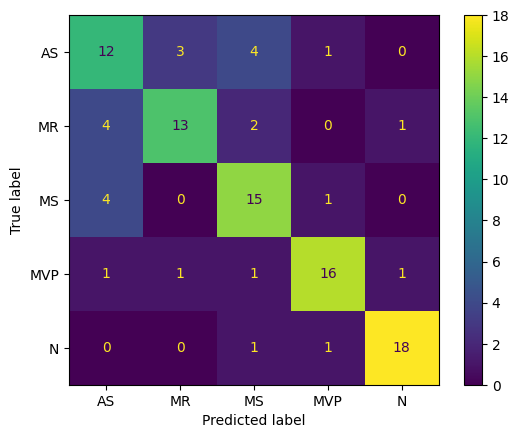

Accuracy : [0.83 0.89 0.87 0.93 0.96] mean:  0.8960000000000001
Precision : [0.57142857 0.76470588 0.65217391 0.84210526 0.9       ] mean:  0.7460827259965771
Sensitivity : [0.6  0.65 0.75 0.8  0.9 ] mean:  0.74
Specificity : [0.8875 0.95   0.9    0.9625 0.975 ] mean:  0.9349999999999999
f1_score: [0.58536585 0.7027027  0.69767442 0.82051282 0.9       ] mean:  0.7412511590957421



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb8L4.csv_2.h5
4/4 [==============================] - 0s 2ms/step


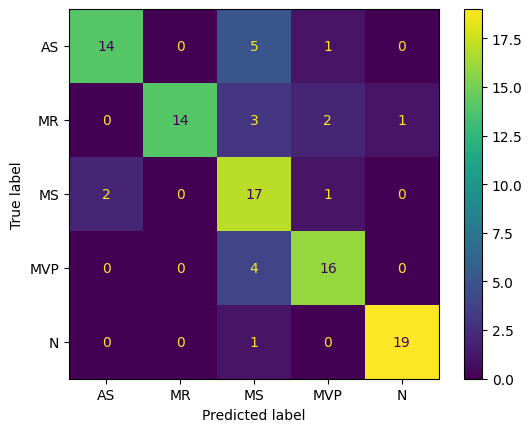

Accuracy : [0.92 0.94 0.84 0.92 0.98] mean:  0.9199999999999999
Precision : [0.875      1.         0.56666667 0.8        0.95      ] mean:  0.8383333333333333
Sensitivity : [0.7  0.7  0.85 0.8  0.95] mean:  0.8
Specificity : [0.975  1.     0.8375 0.95   0.9875] mean:  0.95
f1_score: [0.77777778 0.82352941 0.68       0.8        0.95      ] mean:  0.8062614379084968



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb8L5.csv_3.h5
4/4 [==============================] - 0s 2ms/step


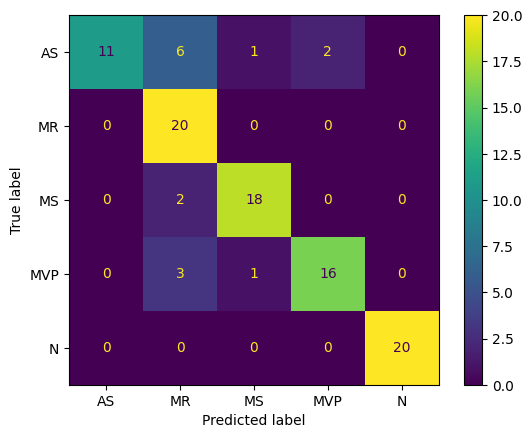

Accuracy : [0.91 0.89 0.96 0.94 1.  ] mean:  0.9399999999999998
Precision : [1.         0.64516129 0.9        0.88888889 1.        ] mean:  0.8868100358422939
Sensitivity : [0.55 1.   0.9  0.8  1.  ] mean:  0.85
Specificity : [1.     0.8625 0.975  0.975  1.    ] mean:  0.9625
f1_score: [0.70967742 0.78431373 0.9        0.84210526 1.        ] mean:  0.8472192816005858



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb8L6.csv_3.h5
4/4 [==============================] - 0s 2ms/step


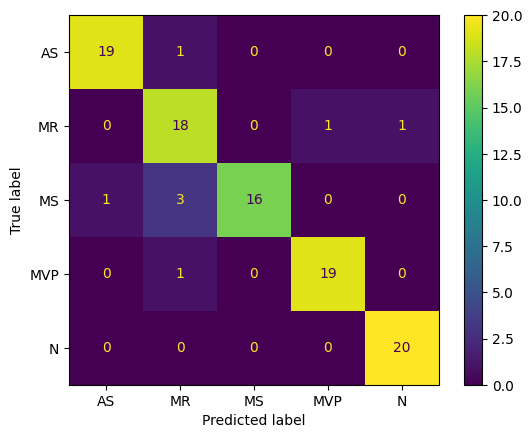

Accuracy : [0.98 0.93 0.96 0.98 0.99] mean:  0.968
Precision : [0.95       0.7826087  1.         0.95       0.95238095] mean:  0.9269979296066253
Sensitivity : [0.95 0.9  0.8  0.95 1.  ] mean:  0.9200000000000002
Specificity : [0.9875 0.9375 1.     0.9875 0.9875] mean:  0.9799999999999999
f1_score: [0.95       0.8372093  0.88888889 0.95       0.97560976] mean:  0.9203415894624063



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb8L7.csv_5.h5
4/4 [==============================] - 0s 3ms/step


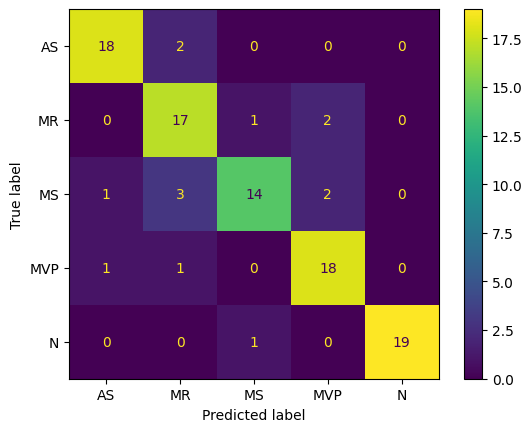

Accuracy : [0.96 0.91 0.92 0.94 0.99] mean:  0.944
Precision : [0.9        0.73913043 0.875      0.81818182 1.        ] mean:  0.8664624505928854
Sensitivity : [0.9  0.85 0.7  0.9  0.95] mean:  0.86
Specificity : [0.975 0.925 0.975 0.95  1.   ] mean:  0.9650000000000001
f1_score: [0.9        0.79069767 0.77777778 0.85714286 0.97435897] mean:  0.8599954567396427



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb8L8.csv_1.h5
4/4 [==============================] - 0s 2ms/step


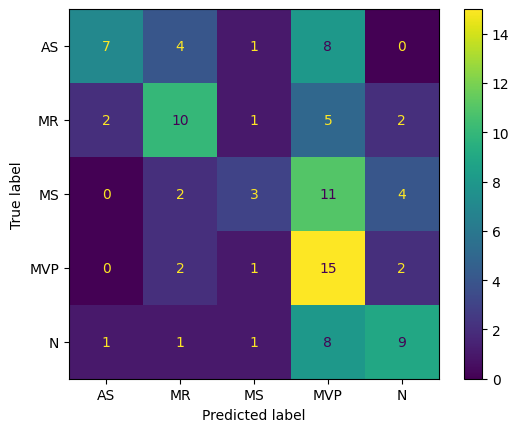

Accuracy : [0.84 0.81 0.79 0.63 0.81] mean:  0.776
Precision : [0.7        0.52631579 0.42857143 0.31914894 0.52941176] mean:  0.5006895837842416
Sensitivity : [0.35 0.5  0.15 0.75 0.45] mean:  0.44000000000000006
Specificity : [0.9625 0.8875 0.95   0.6    0.9   ] mean:  0.86
f1_score: [0.46666667 0.51282051 0.22222222 0.44776119 0.48648649] mean:  0.4271914164451478



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb8L9.csv_5.h5
4/4 [==============================] - 0s 2ms/step


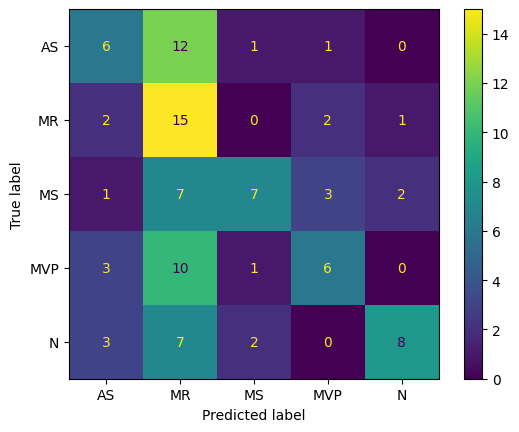

Accuracy : [0.77 0.59 0.83 0.8  0.85] mean:  0.768
Precision : [0.4        0.29411765 0.63636364 0.5        0.72727273] mean:  0.5115508021390374
Sensitivity : [0.3  0.75 0.35 0.3  0.4 ] mean:  0.42000000000000004
Specificity : [0.8875 0.55   0.95   0.925  0.9625] mean:  0.8550000000000001
f1_score: [0.34285714 0.42253521 0.4516129  0.375      0.51612903] mean:  0.4216268579217239



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb8L10.csv_1.h5
4/4 [==============================] - 0s 2ms/step


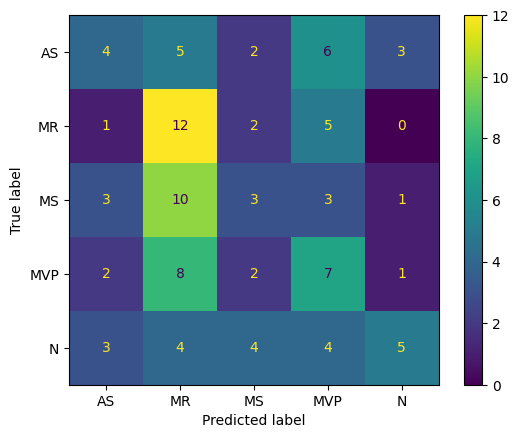

Accuracy : [0.75 0.65 0.73 0.69 0.8 ] mean:  0.724
Precision : [0.30769231 0.30769231 0.23076923 0.28       0.5       ] mean:  0.32523076923076927
Sensitivity : [0.2  0.6  0.15 0.35 0.25] mean:  0.31
Specificity : [0.8875 0.6625 0.875  0.775  0.9375] mean:  0.8274999999999999
f1_score: [0.24242424 0.40677966 0.18181818 0.31111111 0.33333333] mean:  0.29509330594076355



Accuracy All : [0.8400000000000001, 0.828, 0.8960000000000001, 0.9199999999999999, 0.9399999999999998, 0.968, 0.944, 0.776, 0.768, 0.724]
Precision All : [0.5975744635422228, 0.5985562380752943, 0.7460827259965771, 0.8383333333333333, 0.8868100358422939, 0.9269979296066253, 0.8664624505928854, 0.5006895837842416, 0.5115508021390374, 0.32523076923076927]
Sensitivity All : [0.6, 0.57, 0.74, 0.8, 0.85, 0.9200000000000002, 0.86, 0.44000000000000006, 0.42000000000000004, 0.31]
Specificity All : [0.9, 0.8924999999999998, 0.9349999999999999, 0.95, 0.9625, 0.9799999999999999, 0.9650000000000001, 0.86, 0.8550000000000001, 0.827

In [113]:
testingVHD(a8, 8)

Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb9L1.csv_2.h5
4/4 [==============================] - 0s 2ms/step


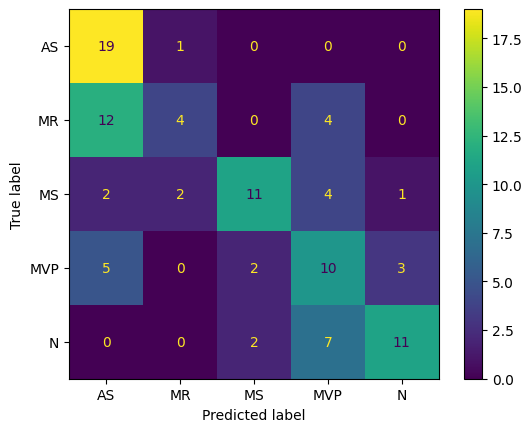

Accuracy : [0.8  0.81 0.87 0.75 0.87] mean:  0.82
Precision : [0.5        0.57142857 0.73333333 0.4        0.73333333] mean:  0.5876190476190476
Sensitivity : [0.95 0.2  0.55 0.5  0.55] mean:  0.55
Specificity : [0.7625 0.9625 0.95   0.8125 0.95  ] mean:  0.8875
f1_score: [0.65517241 0.2962963  0.62857143 0.44444444 0.62857143] mean:  0.5306112023353402



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb9L2.csv_2.h5
4/4 [==============================] - 0s 2ms/step


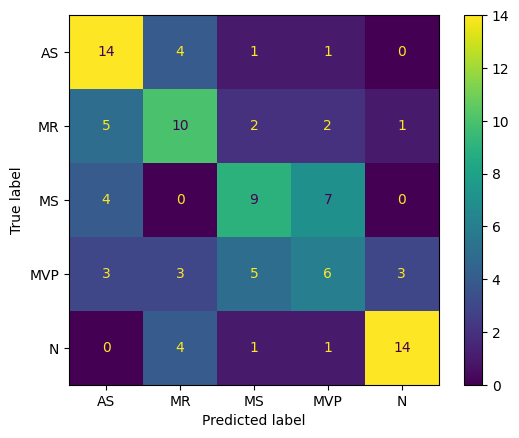

Accuracy : [0.82 0.79 0.8  0.75 0.9 ] mean:  0.812
Precision : [0.53846154 0.47619048 0.5        0.35294118 0.77777778] mean:  0.5290741937800761
Sensitivity : [0.7  0.5  0.45 0.3  0.7 ] mean:  0.53
Specificity : [0.85   0.8625 0.8875 0.8625 0.95  ] mean:  0.8825
f1_score: [0.60869565 0.48780488 0.47368421 0.32432432 0.73684211] mean:  0.5262702340672983



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb9L3.csv_5.h5
4/4 [==============================] - 0s 2ms/step


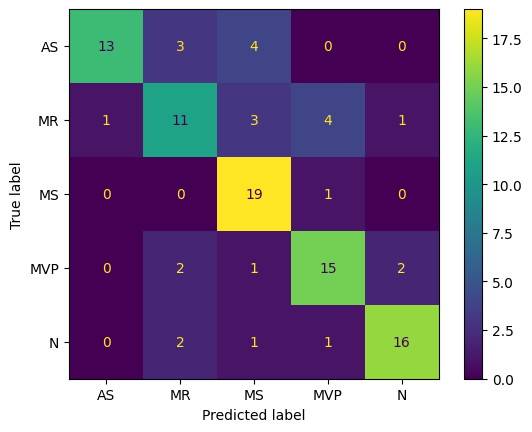

Accuracy : [0.92 0.84 0.9  0.89 0.93] mean:  0.8960000000000001
Precision : [0.92857143 0.61111111 0.67857143 0.71428571 0.84210526] mean:  0.7549289891395154
Sensitivity : [0.65 0.55 0.95 0.75 0.8 ] mean:  0.74
Specificity : [0.9875 0.9125 0.8875 0.925  0.9625] mean:  0.9349999999999999
f1_score: [0.76470588 0.57894737 0.79166667 0.73170732 0.82051282] mean:  0.7375080110053303



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb9L4.csv_2.h5
4/4 [==============================] - 0s 2ms/step


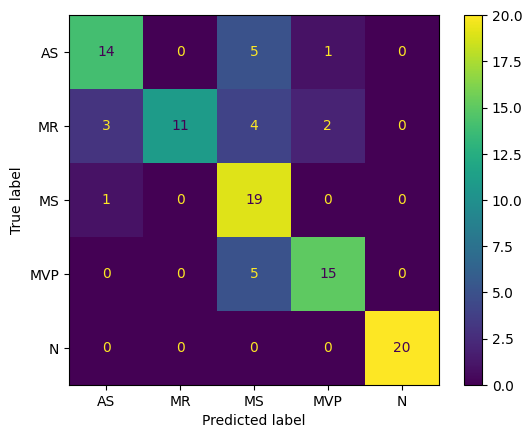

Accuracy : [0.9  0.91 0.85 0.92 1.  ] mean:  0.916
Precision : [0.77777778 1.         0.57575758 0.83333333 1.        ] mean:  0.8373737373737373
Sensitivity : [0.7  0.55 0.95 0.75 1.  ] mean:  0.79
Specificity : [0.95   1.     0.825  0.9625 1.    ] mean:  0.9475
f1_score: [0.73684211 0.70967742 0.71698113 0.78947368 1.        ] mean:  0.7905948681807988



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb9L5.csv_3.h5
4/4 [==============================] - 0s 2ms/step


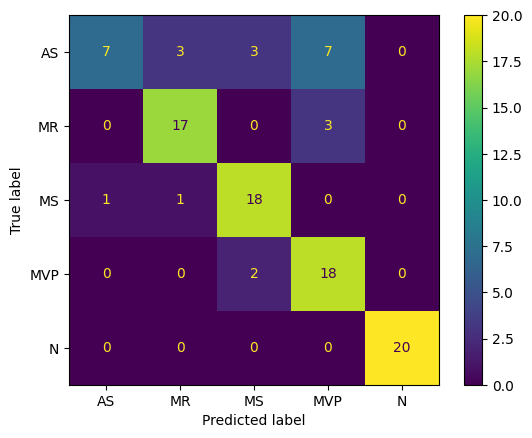

Accuracy : [0.86 0.93 0.93 0.88 1.  ] mean:  0.9199999999999999
Precision : [0.875      0.80952381 0.7826087  0.64285714 1.        ] mean:  0.8219979296066253
Sensitivity : [0.35 0.85 0.9  0.9  1.  ] mean:  0.8
Specificity : [0.9875 0.95   0.9375 0.875  1.    ] mean:  0.95
f1_score: [0.5        0.82926829 0.8372093  0.75       1.        ] mean:  0.7832955190017017



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb9L6.csv_4.h5
4/4 [==============================] - 0s 2ms/step


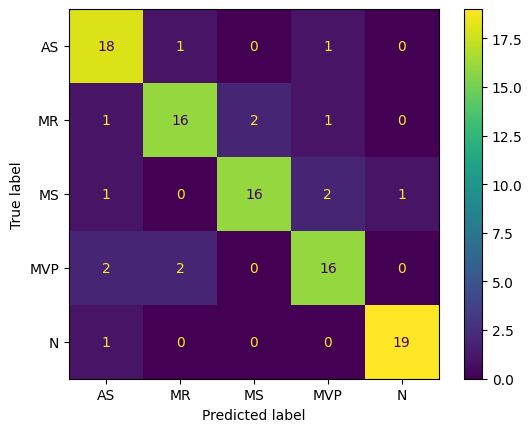

Accuracy : [0.93 0.93 0.94 0.92 0.98] mean:  0.9399999999999998
Precision : [0.7826087  0.84210526 0.88888889 0.8        0.95      ] mean:  0.8527205695397916
Sensitivity : [0.9  0.8  0.8  0.8  0.95] mean:  0.85
Specificity : [0.9375 0.9625 0.975  0.95   0.9875] mean:  0.9625
f1_score: [0.8372093  0.82051282 0.84210526 0.8        0.95      ] mean:  0.8499654771992594



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb9L7.csv_5.h5
4/4 [==============================] - 0s 2ms/step


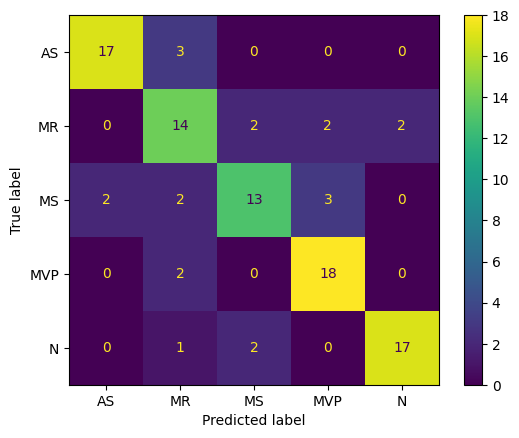

Accuracy : [0.95 0.86 0.89 0.93 0.95] mean:  0.916
Precision : [0.89473684 0.63636364 0.76470588 0.7826087  0.89473684] mean:  0.7946303797158556
Sensitivity : [0.85 0.7  0.65 0.9  0.85] mean:  0.7899999999999999
Specificity : [0.975  0.9    0.95   0.9375 0.975 ] mean:  0.9475
f1_score: [0.87179487 0.66666667 0.7027027  0.8372093  0.87179487] mean:  0.7900336830569389



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb9L8.csv_5.h5
4/4 [==============================] - 0s 2ms/step


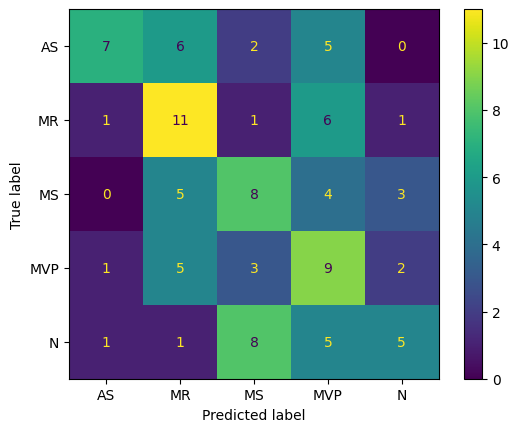

Accuracy : [0.84 0.74 0.74 0.69 0.79] mean:  0.76
Precision : [0.7        0.39285714 0.36363636 0.31034483 0.45454545] mean:  0.44427675772503356
Sensitivity : [0.35 0.55 0.4  0.45 0.25] mean:  0.4
Specificity : [0.9625 0.7875 0.825  0.75   0.925 ] mean:  0.85
f1_score: [0.46666667 0.45833333 0.38095238 0.36734694 0.32258065] mean:  0.3991759929778363



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb9L9.csv_2.h5
4/4 [==============================] - 0s 2ms/step


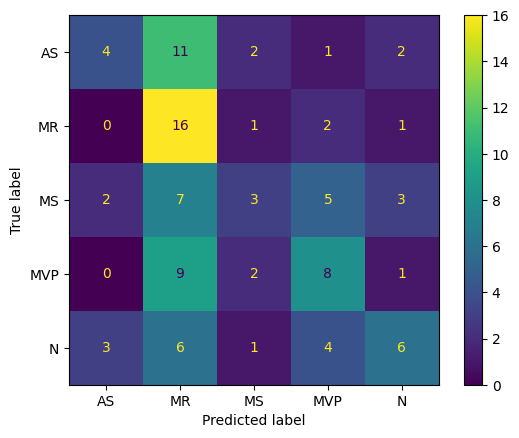

Accuracy : [0.79 0.63 0.77 0.76 0.79] mean:  0.748
Precision : [0.44444444 0.32653061 0.33333333 0.4        0.46153846] mean:  0.39316937031222743
Sensitivity : [0.2  0.8  0.15 0.4  0.3 ] mean:  0.37
Specificity : [0.9375 0.5875 0.925  0.85   0.9125] mean:  0.8425
f1_score: [0.27586207 0.46376812 0.20689655 0.4        0.36363636] mean:  0.34203262005360957



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb9L10.csv_2.h5
4/4 [==============================] - 0s 2ms/step


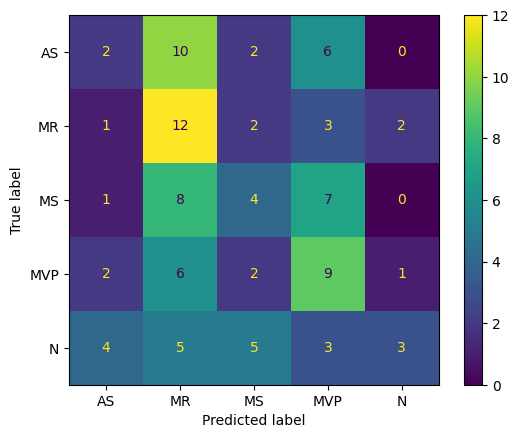

Accuracy : [0.74 0.63 0.73 0.7  0.8 ] mean:  0.72
Precision : [0.2        0.29268293 0.26666667 0.32142857 0.5       ] mean:  0.31615563298490124
Sensitivity : [0.1  0.6  0.2  0.45 0.15] mean:  0.29999999999999993
Specificity : [0.9    0.6375 0.8625 0.7625 0.9625] mean:  0.8250000000000002
f1_score: [0.13333333 0.39344262 0.22857143 0.375      0.23076923] mean:  0.2722233231249625



Accuracy All : [0.82, 0.812, 0.8960000000000001, 0.916, 0.9199999999999999, 0.9399999999999998, 0.916, 0.76, 0.748, 0.72]
Precision All : [0.5876190476190476, 0.5290741937800761, 0.7549289891395154, 0.8373737373737373, 0.8219979296066253, 0.8527205695397916, 0.7946303797158556, 0.44427675772503356, 0.39316937031222743, 0.31615563298490124]
Sensitivity All : [0.55, 0.53, 0.74, 0.79, 0.8, 0.85, 0.7899999999999999, 0.4, 0.37, 0.29999999999999993]
Specificity All : [0.8875, 0.8825, 0.9349999999999999, 0.9475, 0.95, 0.9625, 0.9475, 0.85, 0.8425, 0.8250000000000002]
f1_score All : [0.5306112023353402, 0.52627023

In [114]:
testingVHD(a9, 9)

Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb10L1.csv_2.h5
4/4 [==============================] - 0s 2ms/step


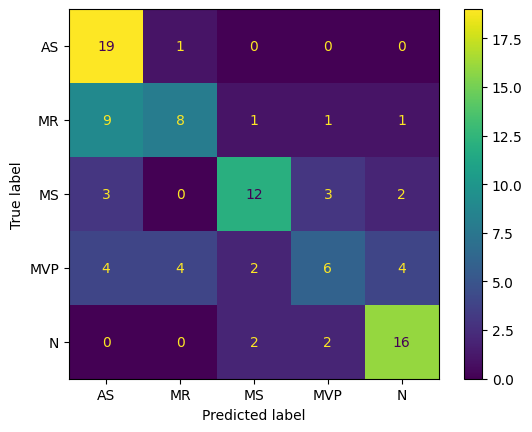

Accuracy : [0.83 0.83 0.87 0.8  0.89] mean:  0.844
Precision : [0.54285714 0.61538462 0.70588235 0.5        0.69565217] mean:  0.6119552570191956
Sensitivity : [0.95 0.4  0.6  0.3  0.8 ] mean:  0.61
Specificity : [0.8    0.9375 0.9375 0.925  0.9125] mean:  0.9024999999999999
f1_score: [0.69090909 0.48484848 0.64864865 0.375      0.74418605] mean:  0.5887184541835705



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb10L2.csv_2.h5
4/4 [==============================] - 0s 2ms/step


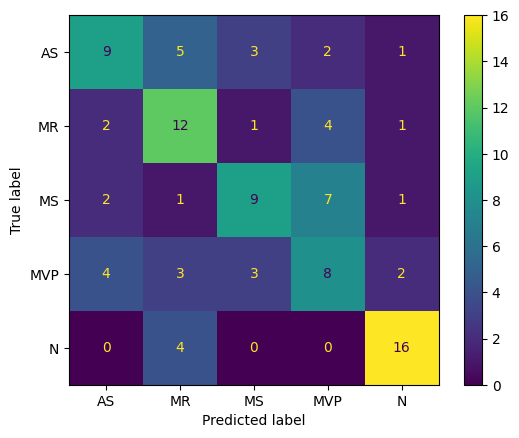

Accuracy : [0.81 0.79 0.82 0.75 0.91] mean:  0.8160000000000001
Precision : [0.52941176 0.48       0.5625     0.38095238 0.76190476] mean:  0.542953781512605
Sensitivity : [0.45 0.6  0.45 0.4  0.8 ] mean:  0.54
Specificity : [0.9    0.8375 0.9125 0.8375 0.9375] mean:  0.885
f1_score: [0.48648649 0.53333333 0.5        0.3902439  0.7804878 ] mean:  0.5381103054273785



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb10L3.csv_2.h5
4/4 [==============================] - 0s 2ms/step


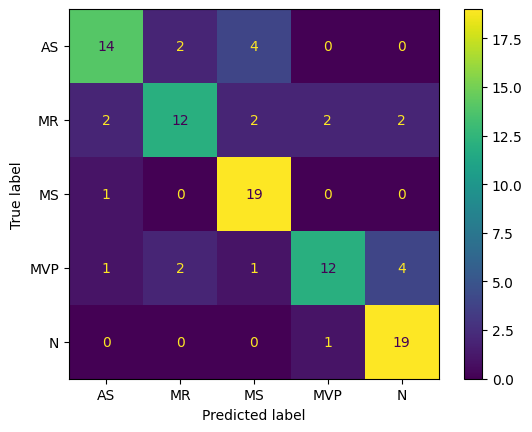

Accuracy : [0.9  0.88 0.92 0.89 0.93] mean:  0.9040000000000001
Precision : [0.77777778 0.75       0.73076923 0.8        0.76      ] mean:  0.7637094017094016
Sensitivity : [0.7  0.6  0.95 0.6  0.95] mean:  0.76
Specificity : [0.95   0.95   0.9125 0.9625 0.925 ] mean:  0.9400000000000001
f1_score: [0.73684211 0.66666667 0.82608696 0.68571429 0.84444444] mean:  0.7519508917220589



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb10L4.csv_5.h5
4/4 [==============================] - 0s 2ms/step


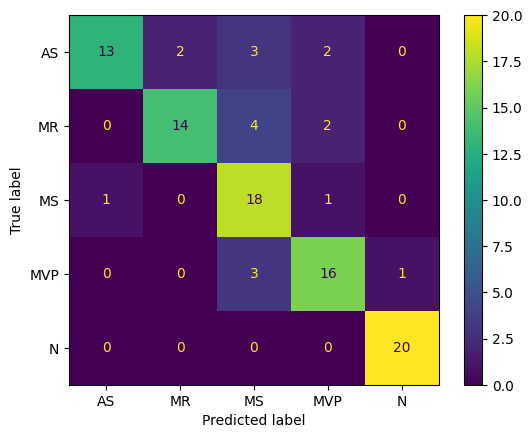

Accuracy : [0.92 0.92 0.88 0.91 0.99] mean:  0.924
Precision : [0.92857143 0.875      0.64285714 0.76190476 0.95238095] mean:  0.8321428571428571
Sensitivity : [0.65 0.7  0.9  0.8  1.  ] mean:  0.8099999999999999
Specificity : [0.9875 0.975  0.875  0.9375 0.9875] mean:  0.9525
f1_score: [0.76470588 0.77777778 0.75       0.7804878  0.97560976] mean:  0.8097162442212656



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb10L5.csv_2.h5
4/4 [==============================] - 0s 2ms/step


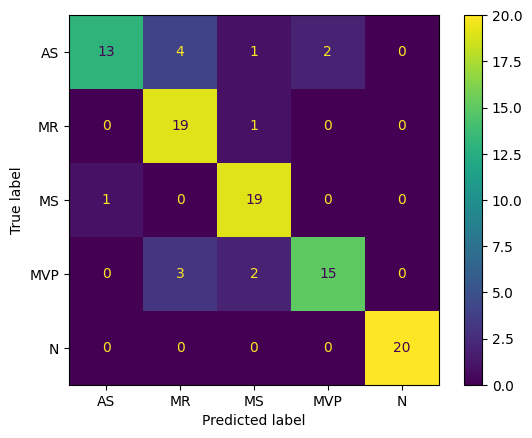

Accuracy : [0.92 0.92 0.95 0.93 1.  ] mean:  0.9440000000000002
Precision : [0.92857143 0.73076923 0.82608696 0.88235294 1.        ] mean:  0.8735561114077738
Sensitivity : [0.65 0.95 0.95 0.75 1.  ] mean:  0.86
Specificity : [0.9875 0.9125 0.95   0.975  1.    ] mean:  0.9649999999999999
f1_score: [0.76470588 0.82608696 0.88372093 0.81081081 1.        ] mean:  0.8570649159836099



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb10L6.csv_4.h5
4/4 [==============================] - 0s 2ms/step


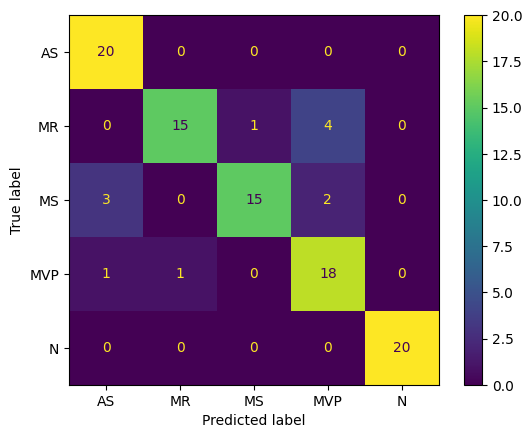

Accuracy : [0.96 0.94 0.94 0.92 1.  ] mean:  0.952
Precision : [0.83333333 0.9375     0.9375     0.75       1.        ] mean:  0.8916666666666668
Sensitivity : [1.   0.75 0.75 0.9  1.  ] mean:  0.8800000000000001
Specificity : [0.95   0.9875 0.9875 0.925  1.    ] mean:  0.97
f1_score: [0.90909091 0.83333333 0.83333333 0.81818182 1.        ] mean:  0.8787878787878789



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb10L7.csv_3.h5
4/4 [==============================] - 0s 2ms/step


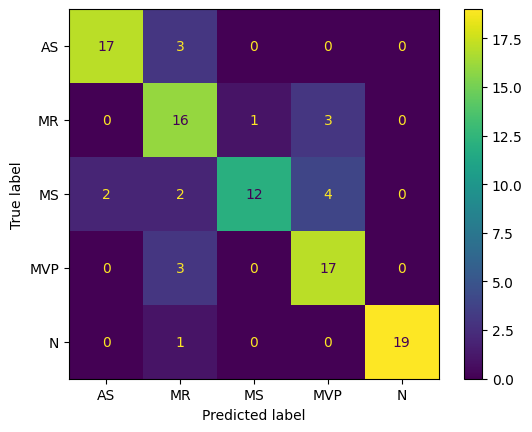

Accuracy : [0.95 0.87 0.91 0.9  0.99] mean:  0.924
Precision : [0.89473684 0.64       0.92307692 0.70833333 1.        ] mean:  0.8332294197031039
Sensitivity : [0.85 0.8  0.6  0.85 0.95] mean:  0.8099999999999999
Specificity : [0.975  0.8875 0.9875 0.9125 1.    ] mean:  0.9524999999999999
f1_score: [0.87179487 0.71111111 0.72727273 0.77272727 0.97435897] mean:  0.8114529914529915



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb10L8.csv_5.h5
4/4 [==============================] - 0s 2ms/step


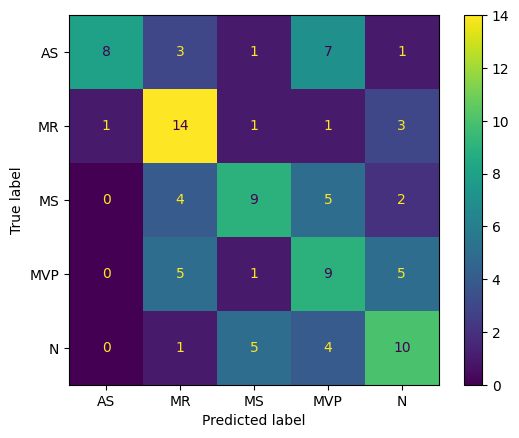

Accuracy : [0.87 0.81 0.81 0.72 0.79] mean:  0.8
Precision : [0.88888889 0.51851852 0.52941176 0.34615385 0.47619048] mean:  0.5518326988915224
Sensitivity : [0.4  0.7  0.45 0.45 0.5 ] mean:  0.5
Specificity : [0.9875 0.8375 0.9    0.7875 0.8625] mean:  0.875
f1_score: [0.55172414 0.59574468 0.48648649 0.39130435 0.48780488] mean:  0.5026129062286905



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb10L9.csv_4.h5
4/4 [==============================] - 0s 2ms/step


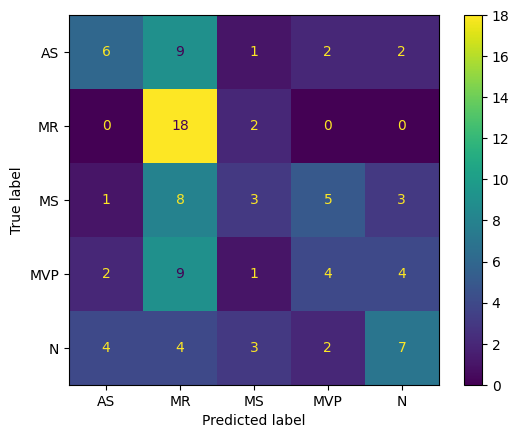

Accuracy : [0.79 0.68 0.76 0.75 0.78] mean:  0.7520000000000001
Precision : [0.46153846 0.375      0.3        0.30769231 0.4375    ] mean:  0.37634615384615383
Sensitivity : [0.3  0.9  0.15 0.2  0.35] mean:  0.38
Specificity : [0.9125 0.625  0.9125 0.8875 0.8875] mean:  0.8450000000000001
f1_score: [0.36363636 0.52941176 0.2        0.24242424 0.38888889] mean:  0.3448722519310755



Processing ../modelh5/CNN_NT/best_model/CNN_NT_KFold_data_MfccDwtChromaCqtdb10L10.csv_5.h5
4/4 [==============================] - 0s 2ms/step


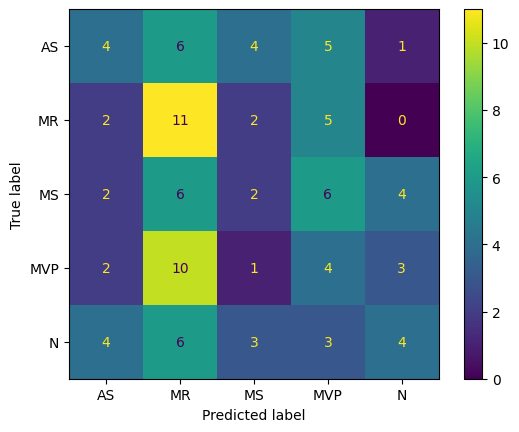

Accuracy : [0.74 0.63 0.72 0.65 0.76] mean:  0.7
Precision : [0.28571429 0.28205128 0.16666667 0.17391304 0.33333333] mean:  0.2483357222487657
Sensitivity : [0.2  0.55 0.1  0.2  0.2 ] mean:  0.25
Specificity : [0.875  0.65   0.875  0.7625 0.9   ] mean:  0.8125
f1_score: [0.23529412 0.37288136 0.125      0.18604651 0.25      ] mean:  0.2338443970414338



Accuracy All : [0.844, 0.8160000000000001, 0.9040000000000001, 0.924, 0.9440000000000002, 0.952, 0.924, 0.8, 0.7520000000000001, 0.7]
Precision All : [0.6119552570191956, 0.542953781512605, 0.7637094017094016, 0.8321428571428571, 0.8735561114077738, 0.8916666666666668, 0.8332294197031039, 0.5518326988915224, 0.37634615384615383, 0.2483357222487657]
Sensitivity All : [0.61, 0.54, 0.76, 0.8099999999999999, 0.86, 0.8800000000000001, 0.8099999999999999, 0.5, 0.38, 0.25]
Specificity All : [0.9024999999999999, 0.885, 0.9400000000000001, 0.9525, 0.9649999999999999, 0.97, 0.9524999999999999, 0.875, 0.8450000000000001, 0.8125]
f1_score All : [

In [115]:
testingVHD(a10, 10)